In [1]:
import os
import wfdb
import pywt
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.decomposition import TruncatedSVD
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt

## 1

Вивід даних файлів .edf та .edf.qrs, де в .edf знахоиться сам сигнал ЕКГ записаний із 5-ти каналів:
1-й - канал дитини, Direct_1
2-5 - канали матері, Abdomen_1, 2, 3, 4

У файлах із розширенням .edf.qrs знаходяться розміщення R-піків для кожного каналу сигналів.

Файл:./abdominal-and-direct-fetal-ecg-database-1.0.0/abdominal-and-direct-fetal-ecg-database-1.0.0\r01.edf


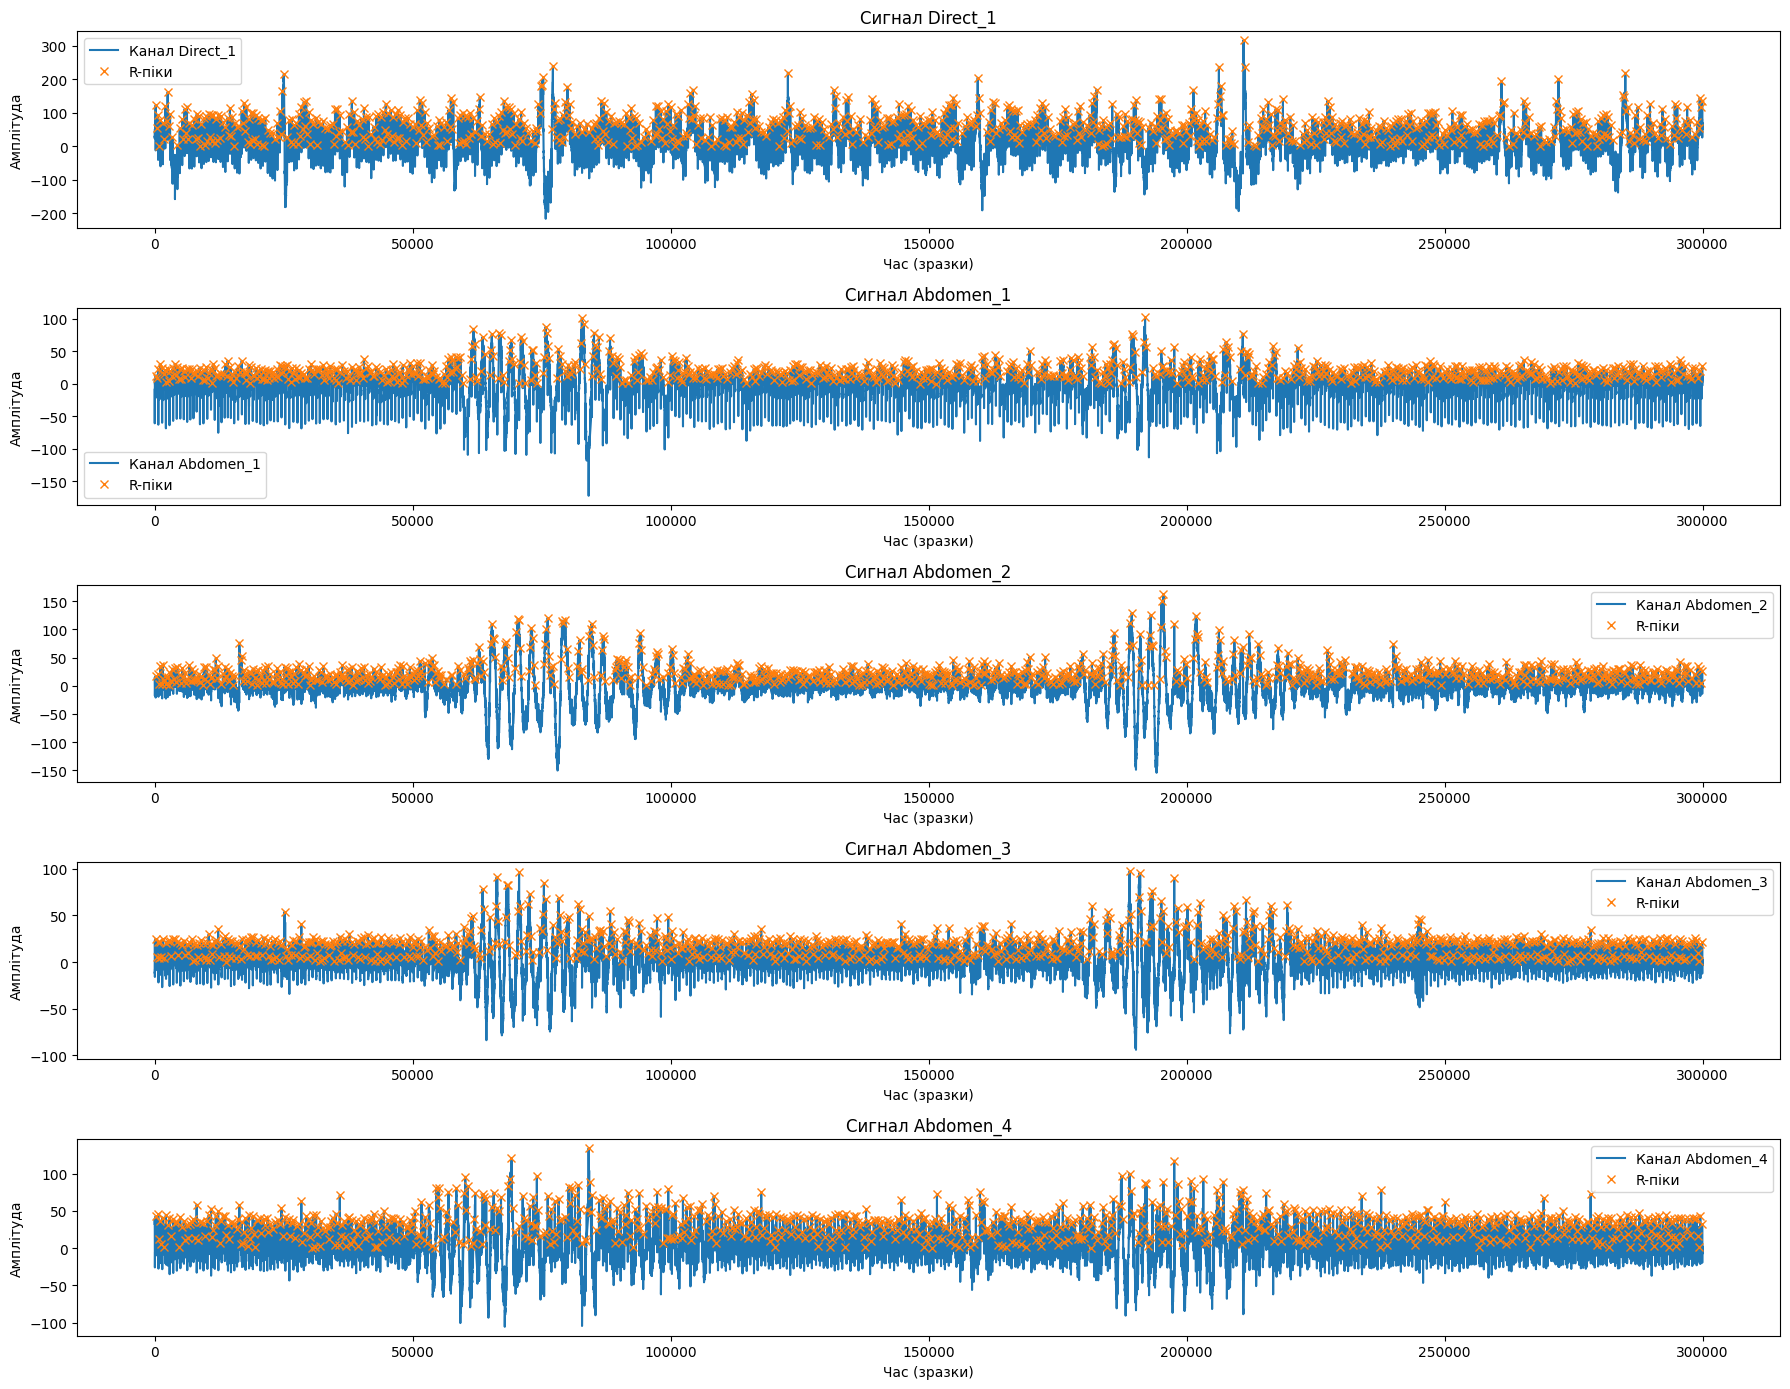

Файл:./abdominal-and-direct-fetal-ecg-database-1.0.0/abdominal-and-direct-fetal-ecg-database-1.0.0\r04.edf


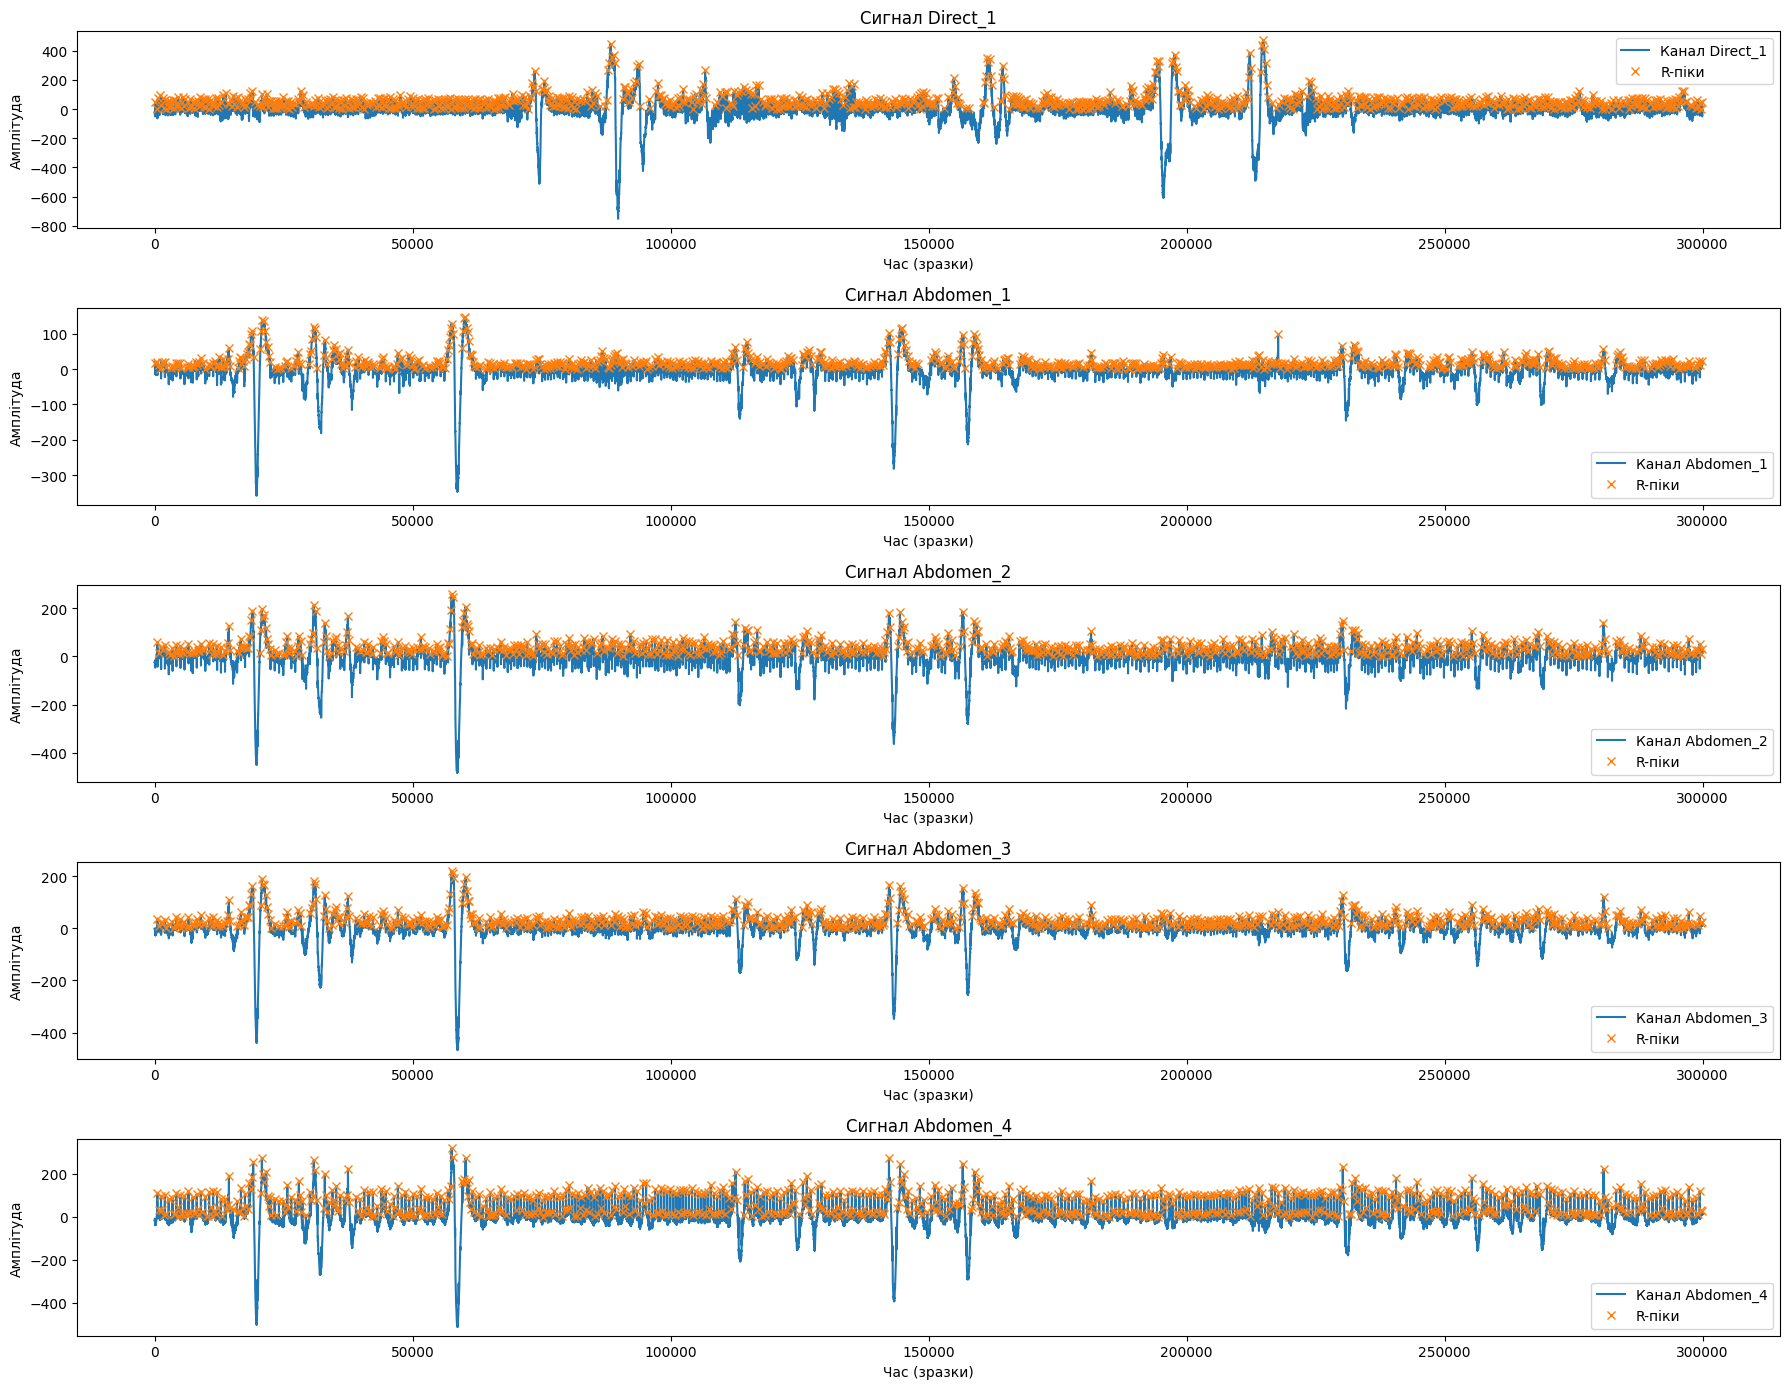

Файл:./abdominal-and-direct-fetal-ecg-database-1.0.0/abdominal-and-direct-fetal-ecg-database-1.0.0\r07.edf


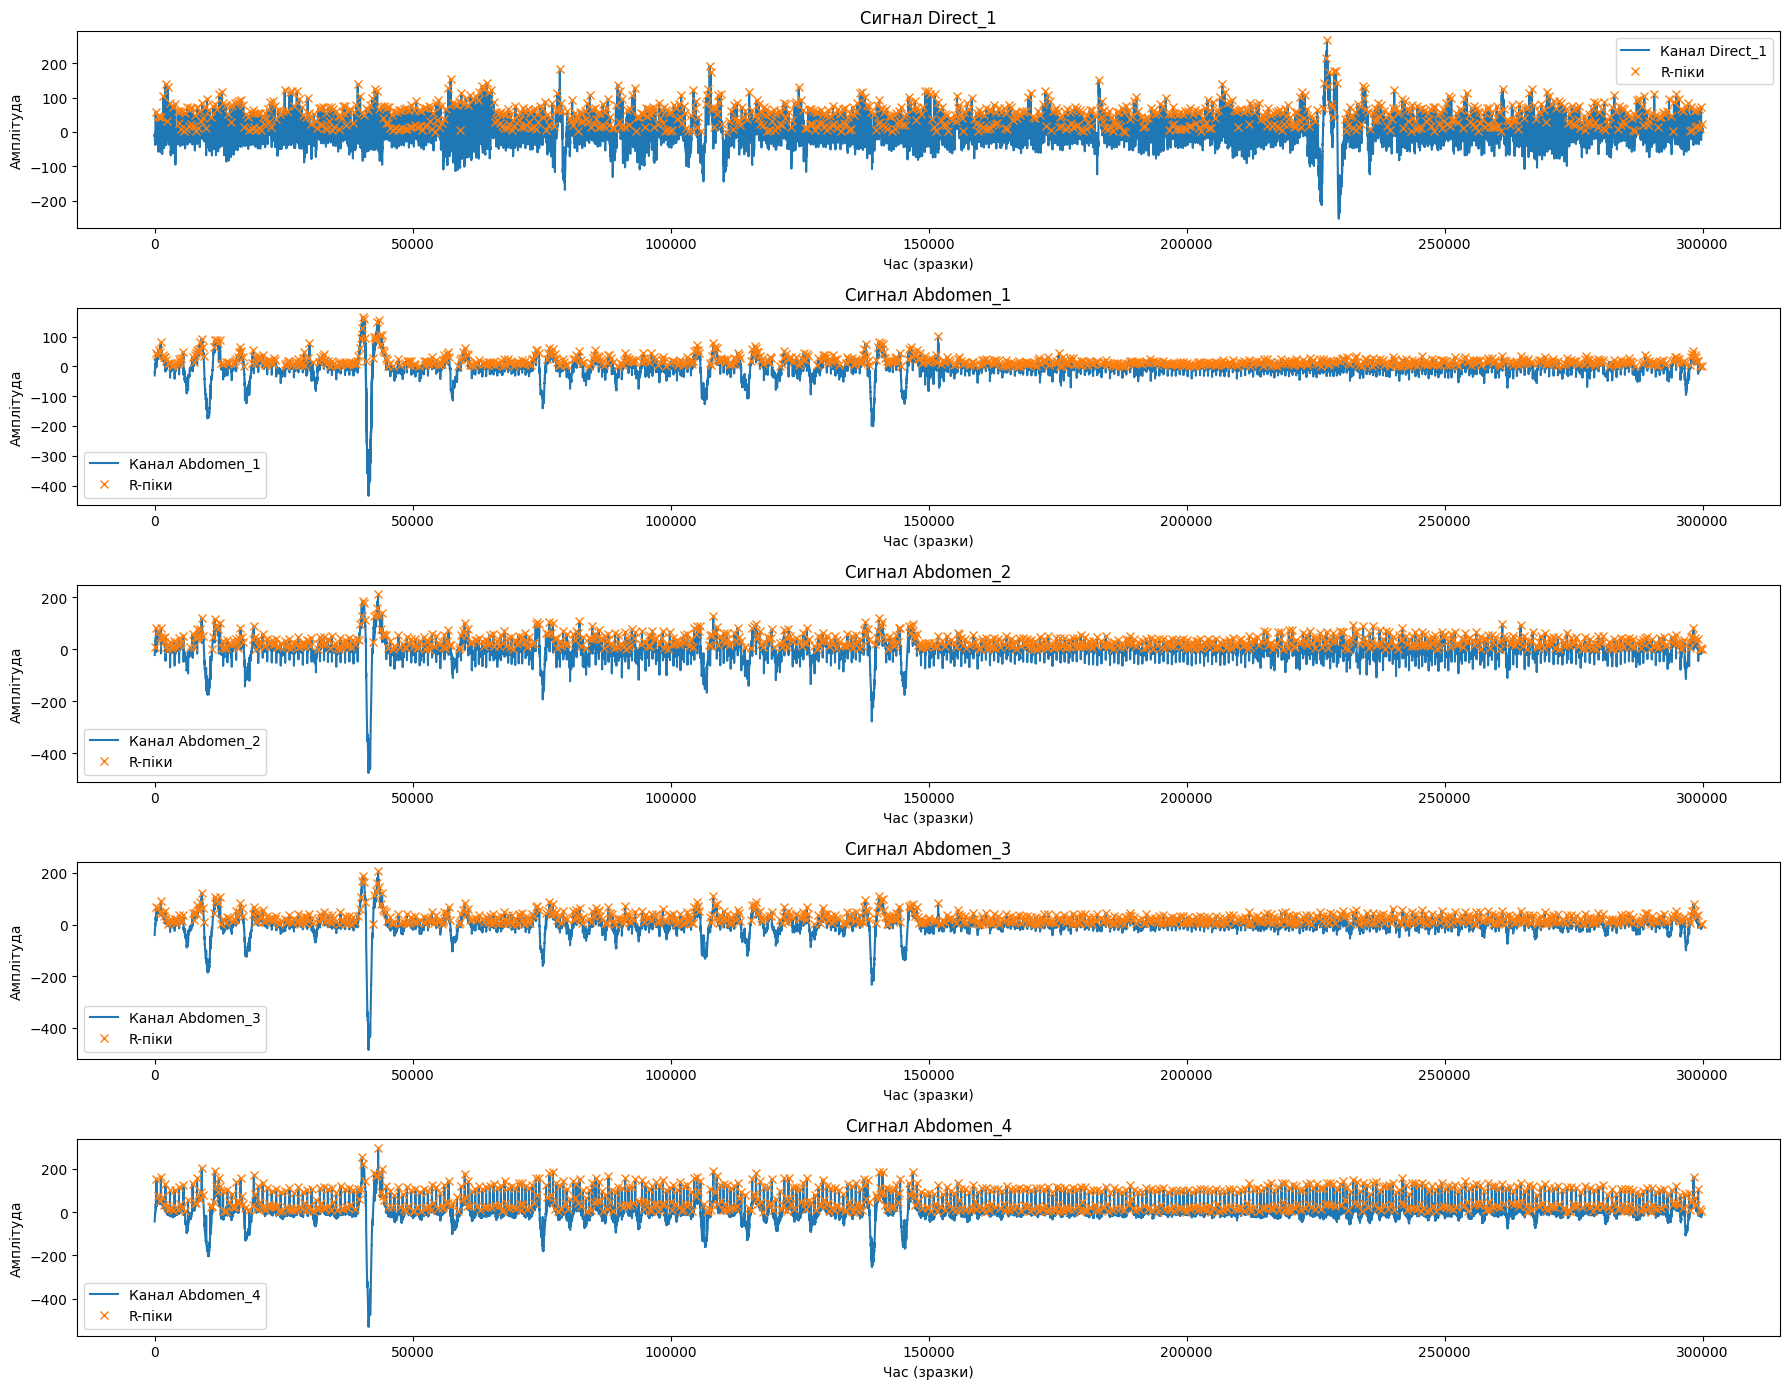

Файл:./abdominal-and-direct-fetal-ecg-database-1.0.0/abdominal-and-direct-fetal-ecg-database-1.0.0\r08.edf


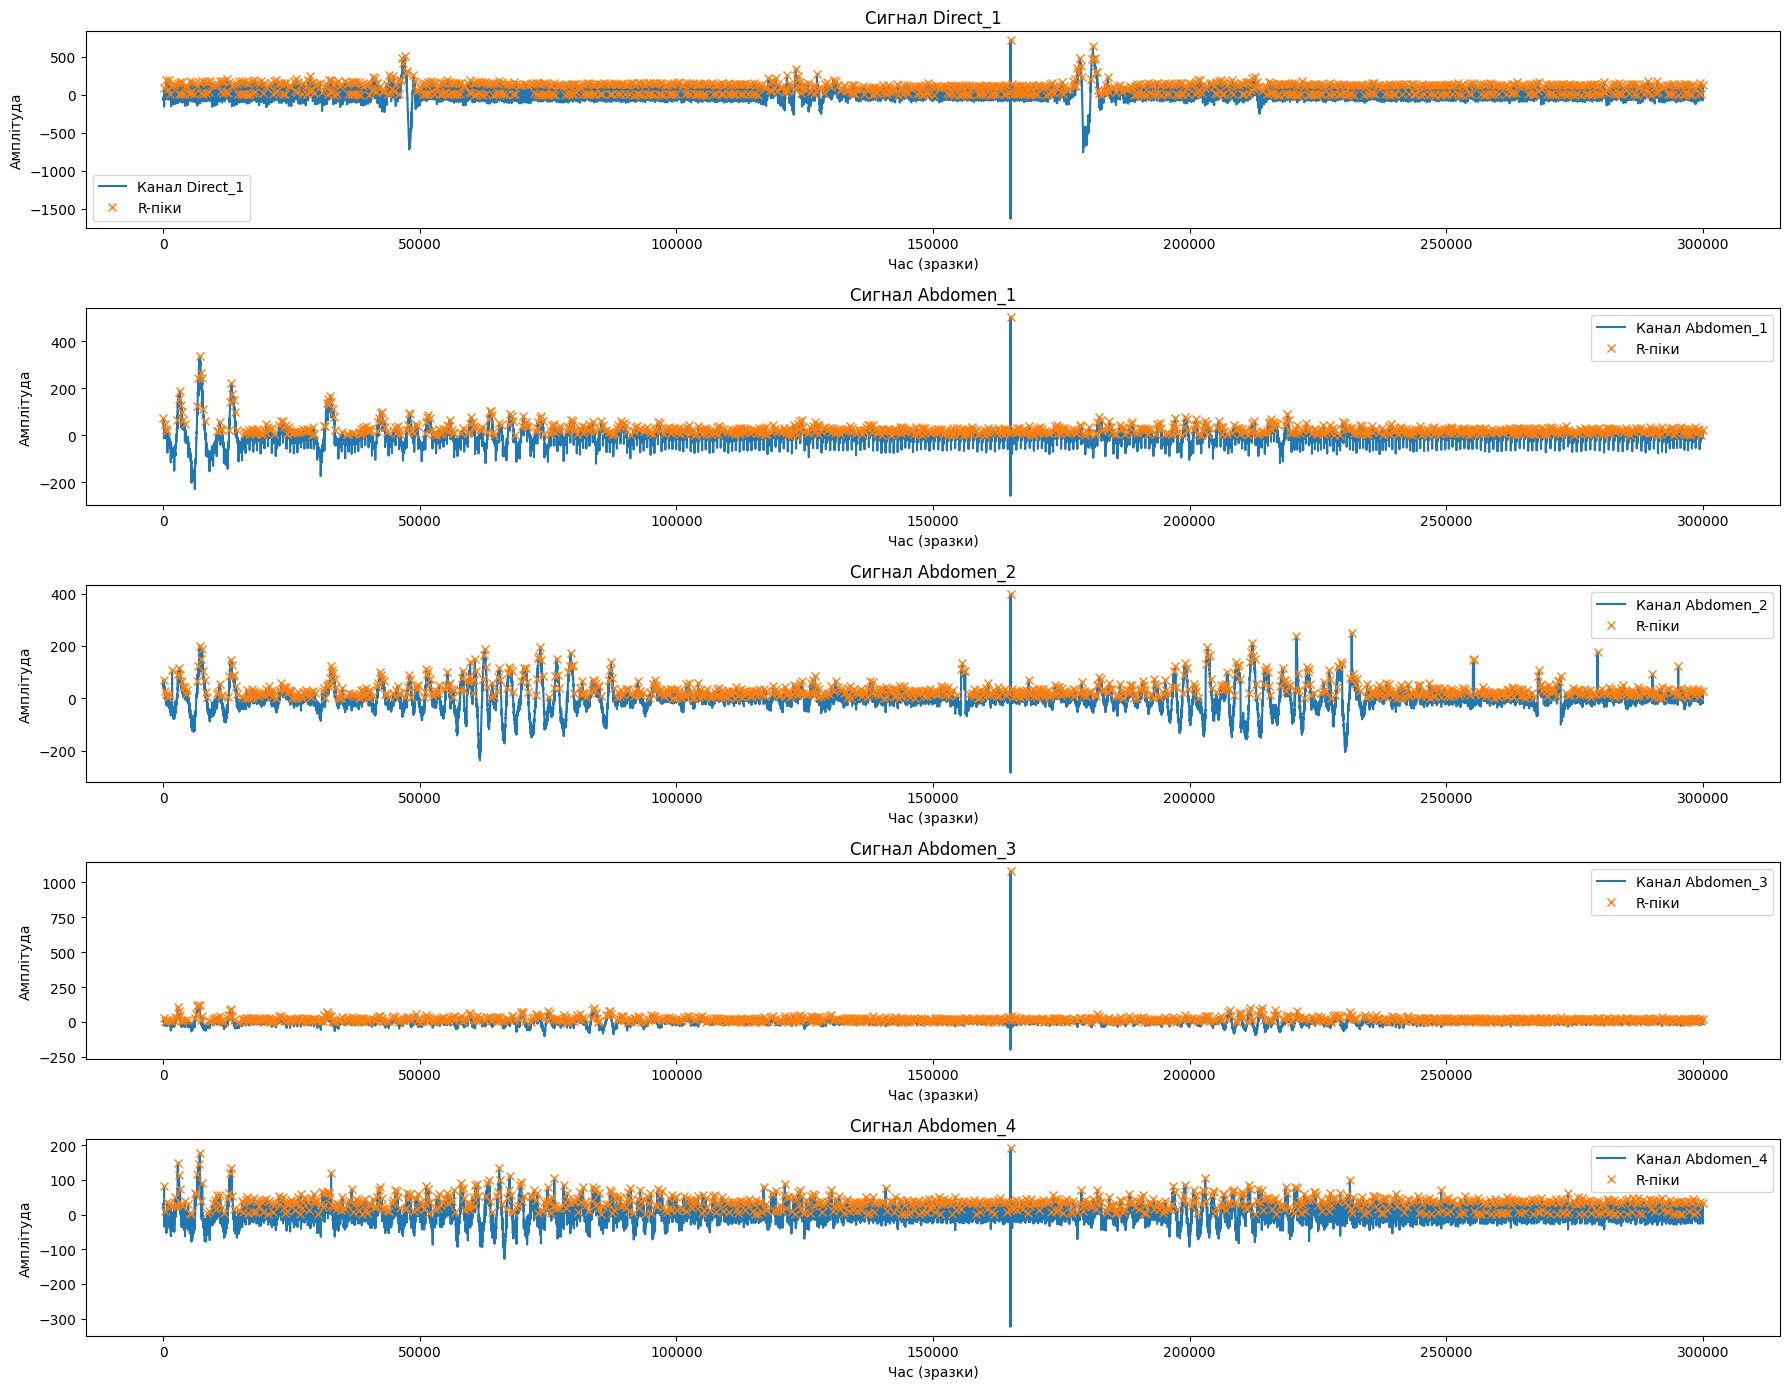

Файл:./abdominal-and-direct-fetal-ecg-database-1.0.0/abdominal-and-direct-fetal-ecg-database-1.0.0\r10.edf


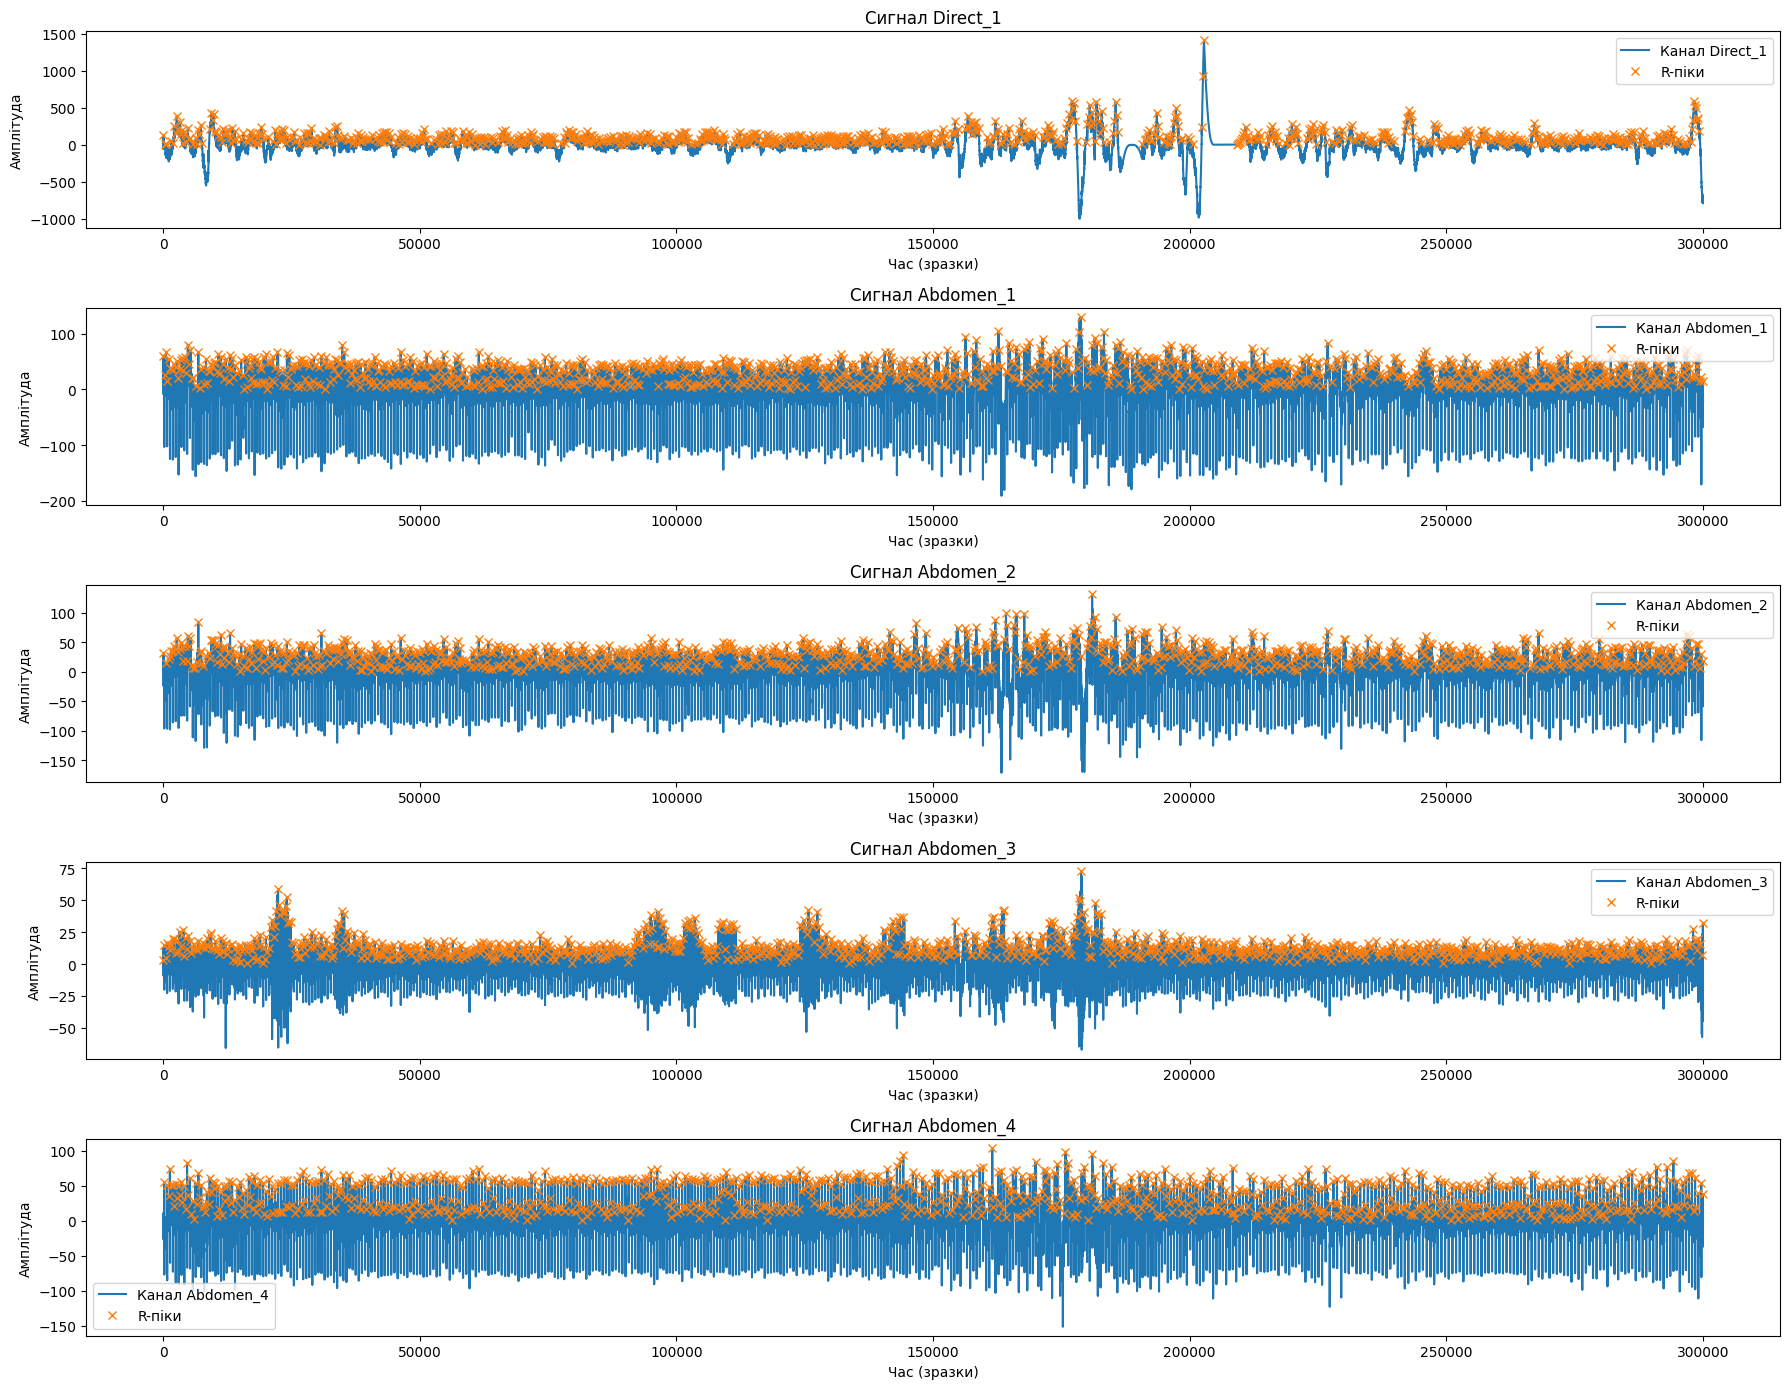

In [3]:
folder_path = "./abdominal-and-direct-fetal-ecg-database-1.0.0/abdominal-and-direct-fetal-ecg-database-1.0.0"

edf_files = {}
qrs_files = {}

for file_name in os.listdir(folder_path):
    if file_name.endswith(".edf"):
        record_name = file_name[:-4]
        edf_files[record_name] = os.path.join(folder_path, file_name)
    elif file_name.endswith(".edf.qrs"):
        record_name = file_name[:-8]
        qrs_files[record_name] = os.path.join(folder_path, file_name)

for record_name in edf_files.keys():
    if record_name in qrs_files:
        edf_file_path = edf_files[record_name]
        qrs_file_path = qrs_files[record_name]

        annotation = wfdb.rdann(qrs_file_path[:-4], 'qrs')
        r_peaks = annotation.sample
        
        with pyedflib.EdfReader(edf_file_path) as edf_file:
            num_signals = edf_file.signals_in_file
            signals = [edf_file.readSignal(i) for i in range(num_signals)]
            channel_labels = edf_file.getSignalLabels()
            
            print(f"Файл:{edf_file_path}")
            plt.figure(figsize=(18, 14))
            for i, signal in enumerate(signals):
                    plt.subplot(num_signals, 1, i + 1)
                    plt.plot(signal, label=f"Канал {channel_labels[i]}")

                    peaks, _ = find_peaks(signal, height=0.5, distance=200)
                    plt.plot(peaks, signal[peaks], "x", label="R-піки")

                    plt.title(f"Сигнал {channel_labels[i]}")
                    plt.legend()
                    plt.xlabel("Час (зразки)")
                    plt.ylabel("Амплітуда")
                    
            plt.tight_layout()
            plt.show()

## 2

Виведення спектрів наших сигналів. 
Як ми можемо помітити, наш сигнал, переважно, складається із низькочастотних компонент із певними піками на високих компонентах.

Файл: r01.edf, Каналів: 5


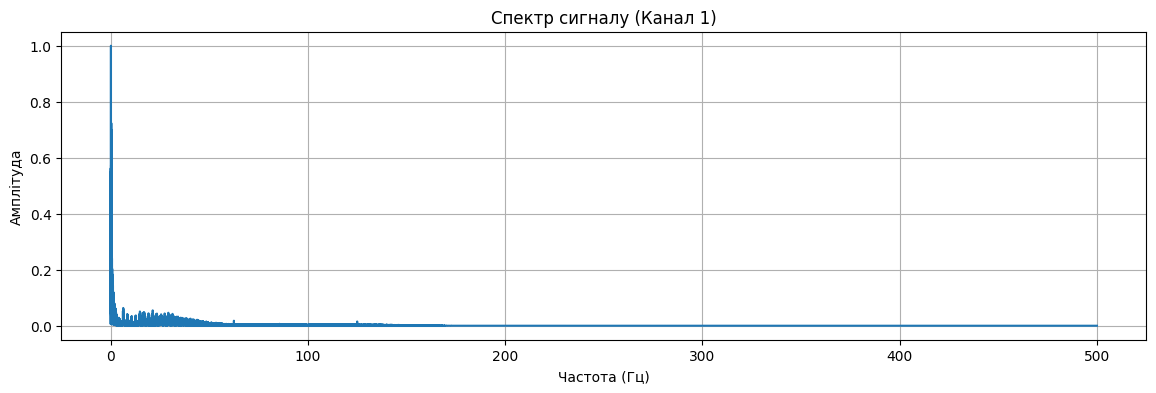

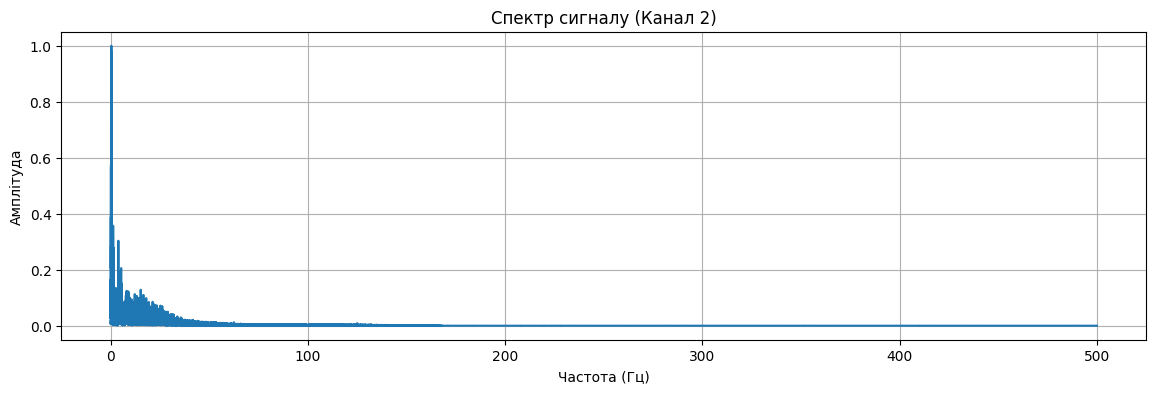

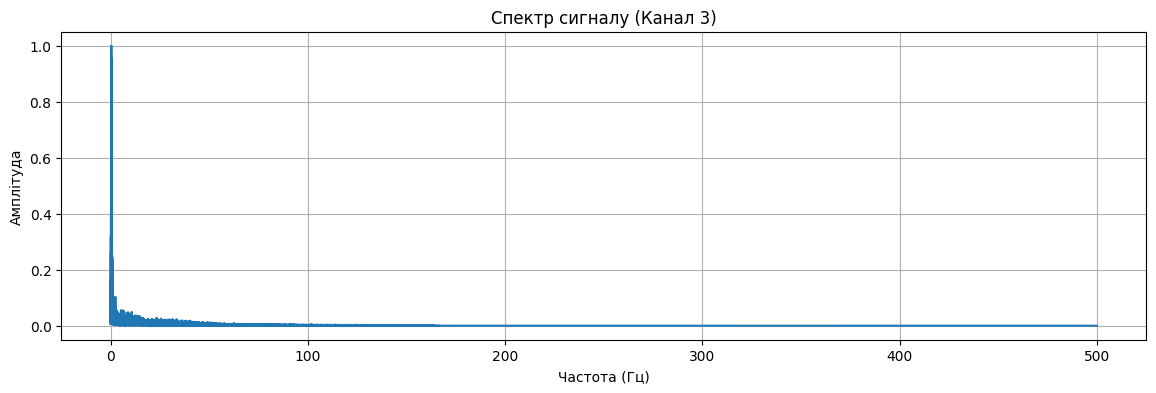

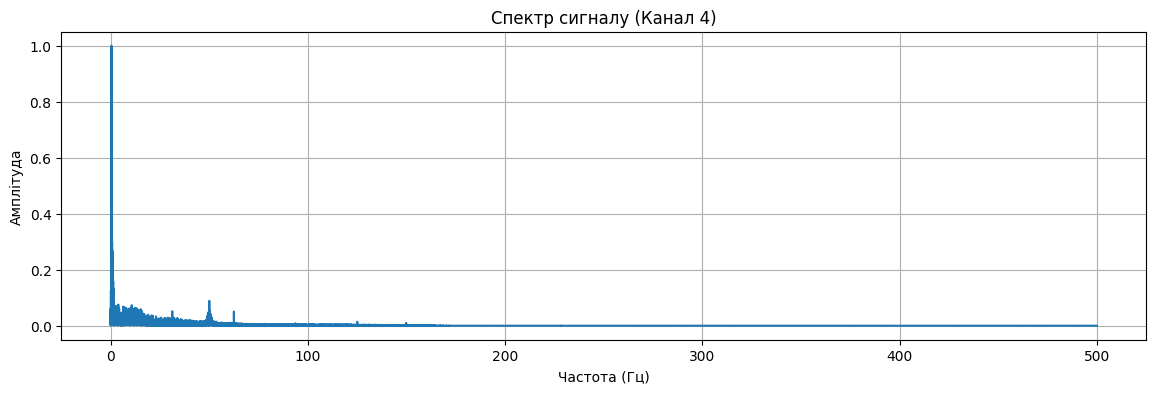

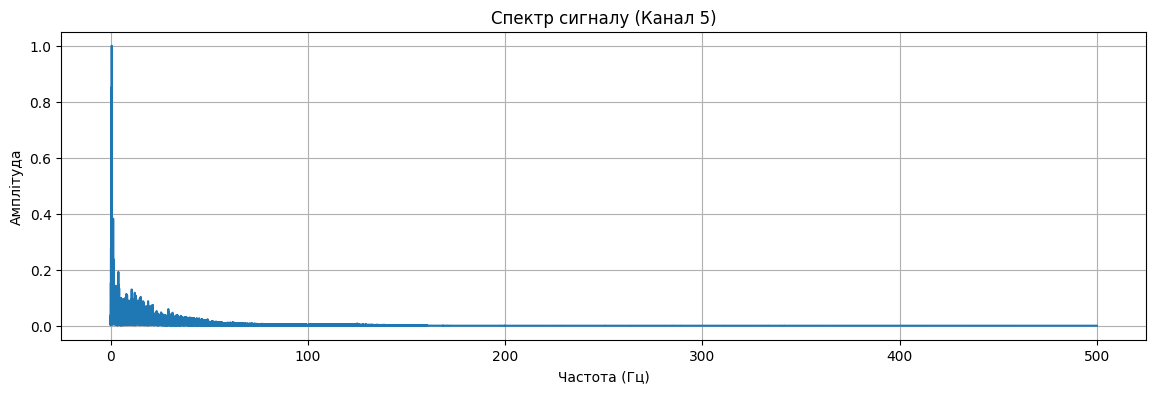

Файл: r04.edf, Каналів: 5


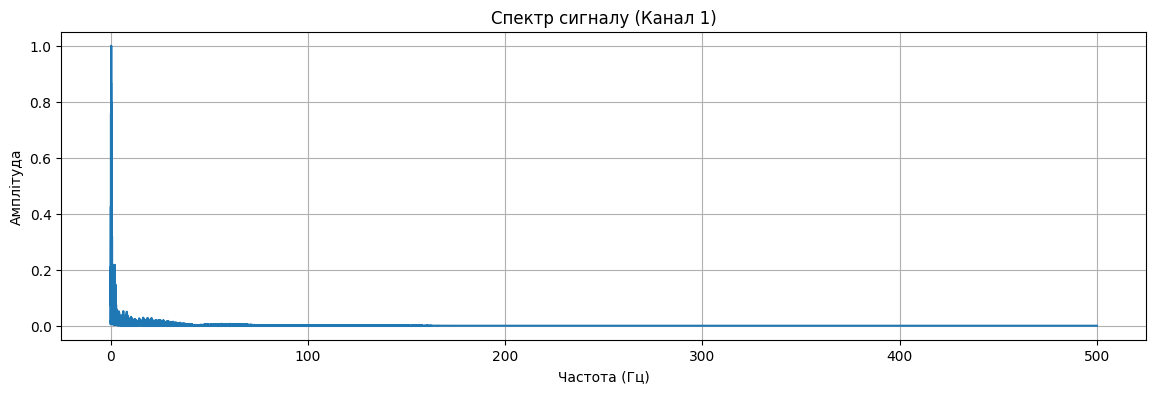

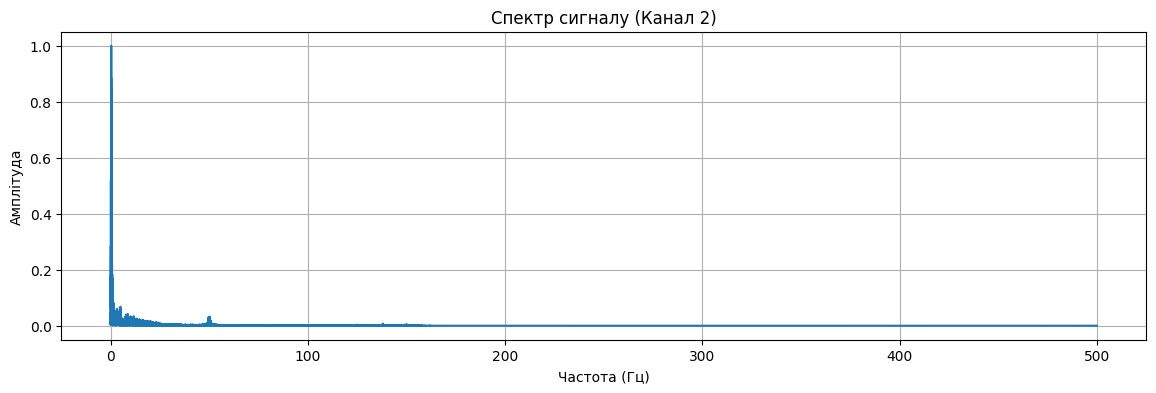

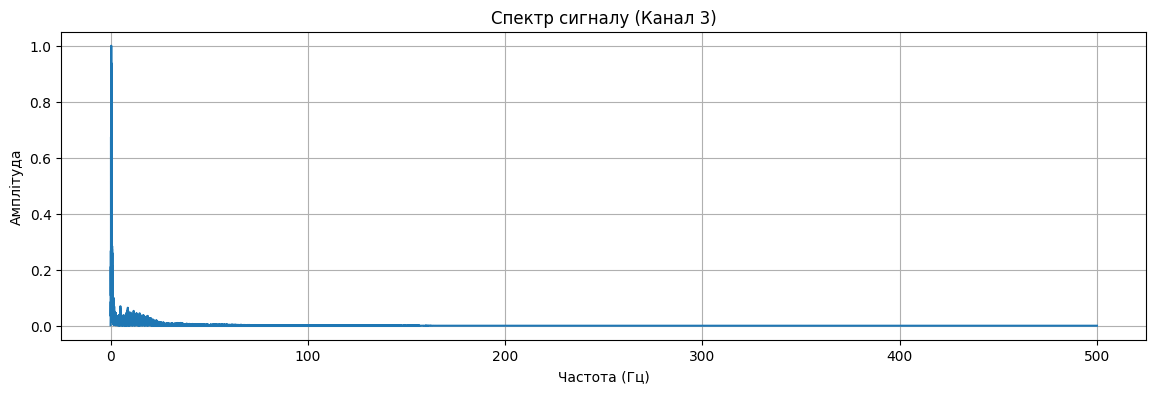

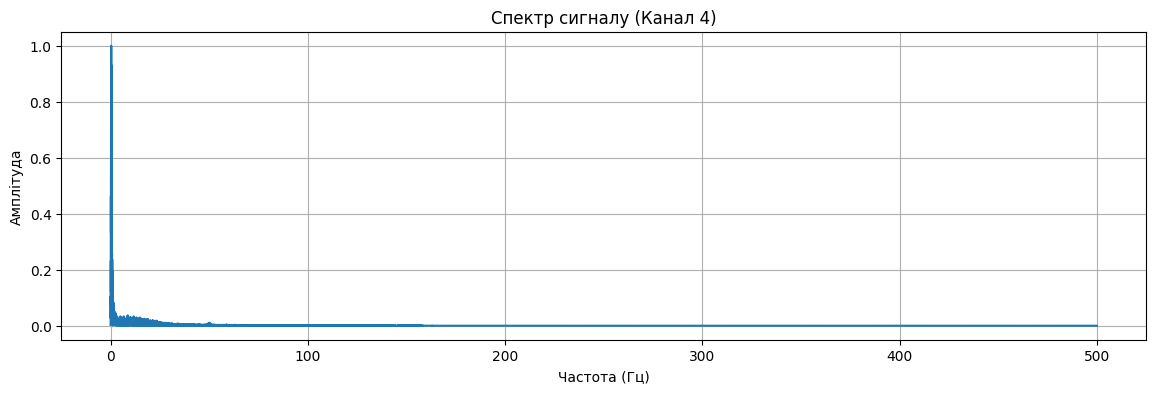

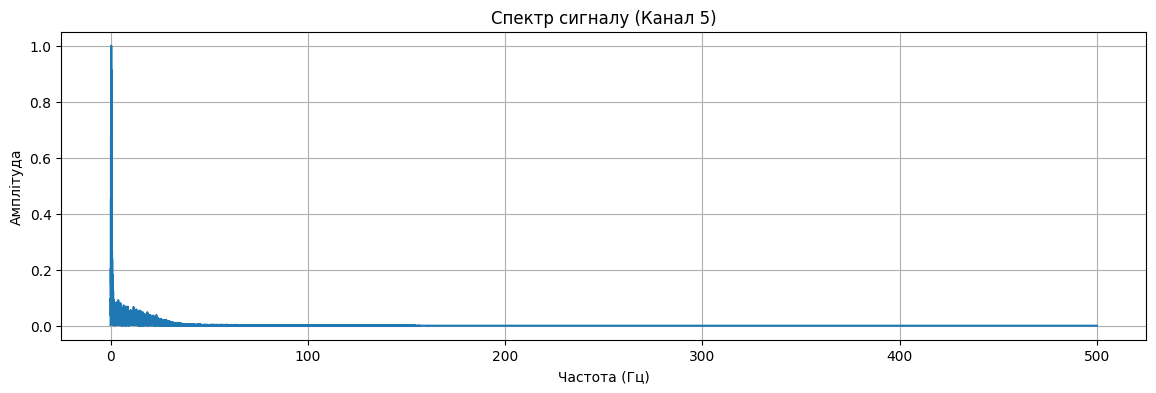

Файл: r07.edf, Каналів: 5


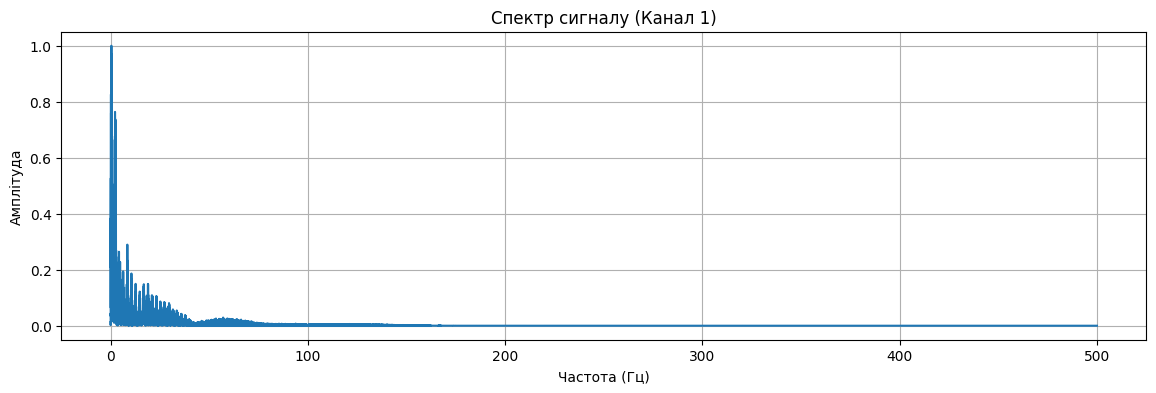

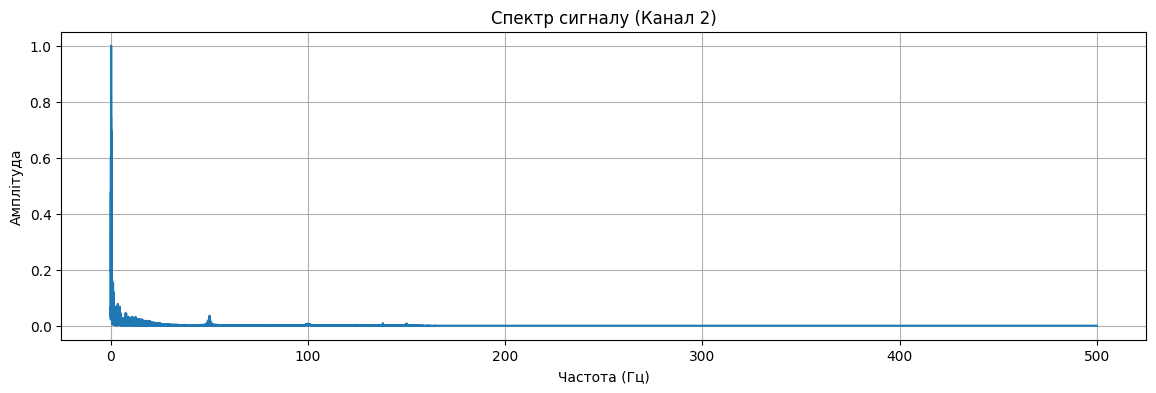

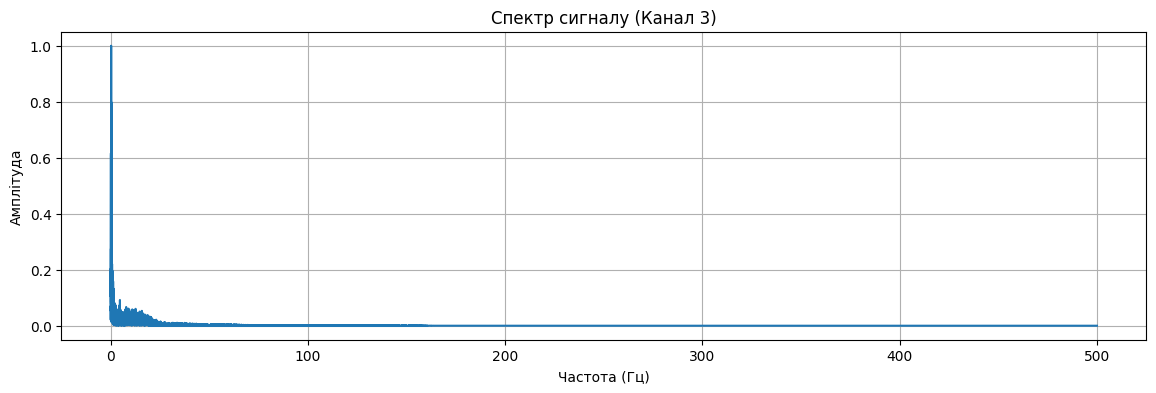

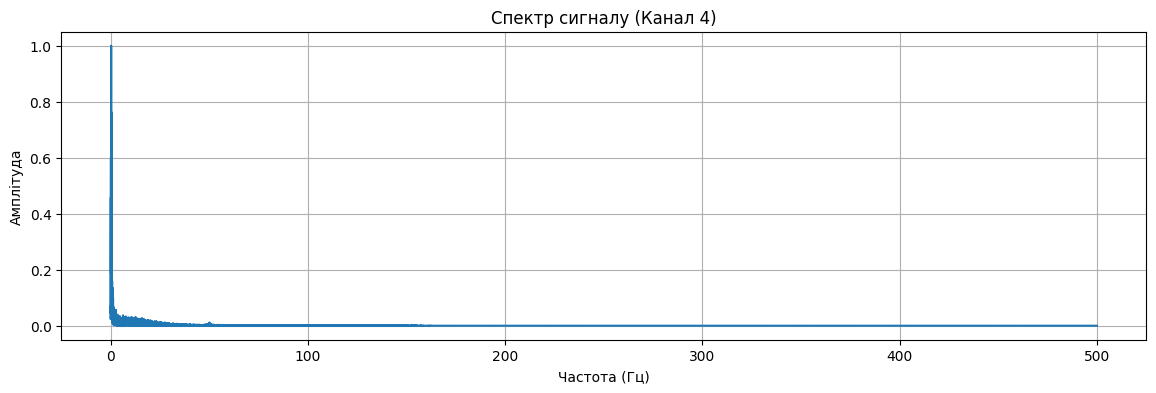

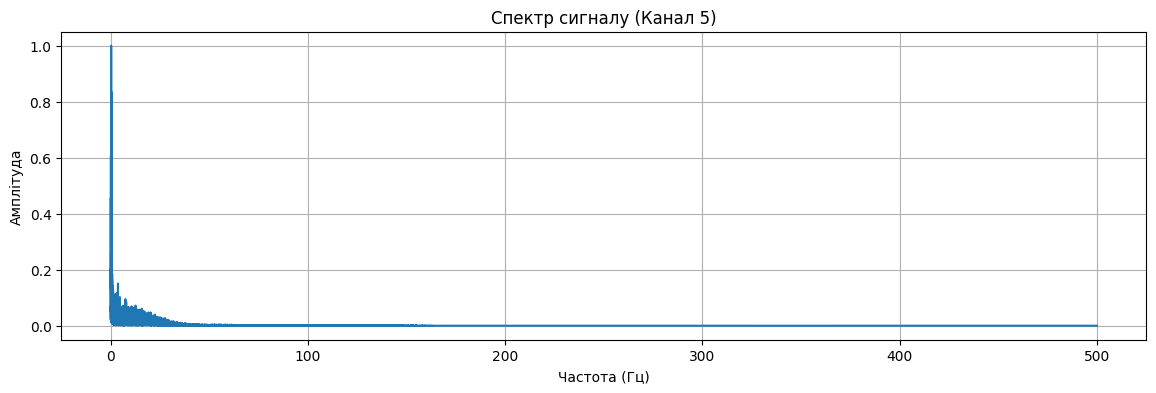

Файл: r08.edf, Каналів: 5


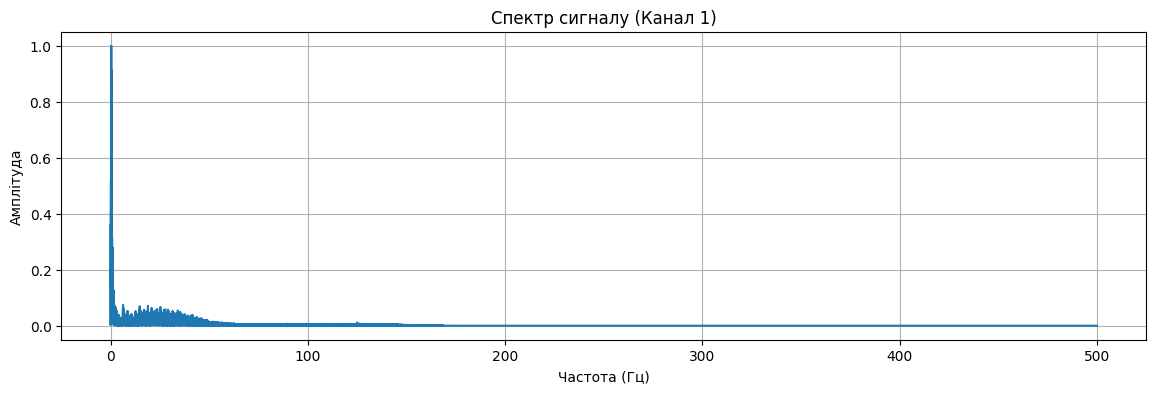

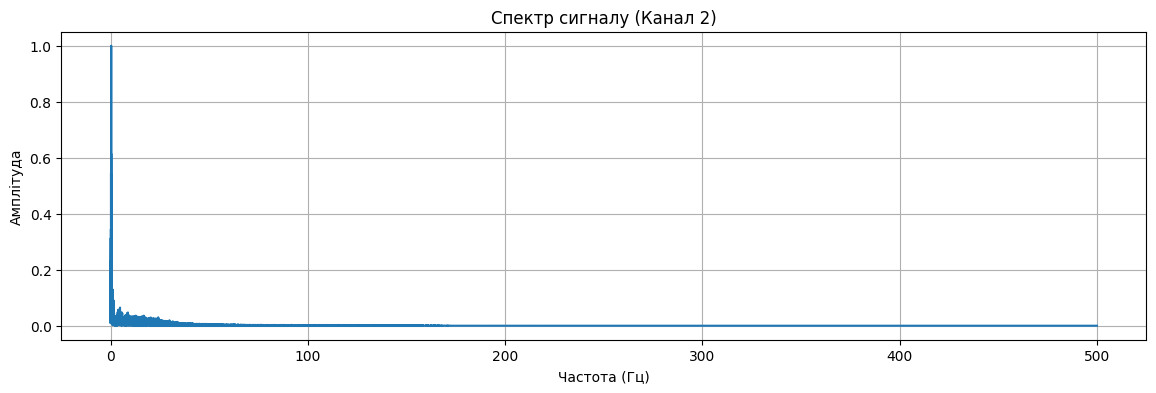

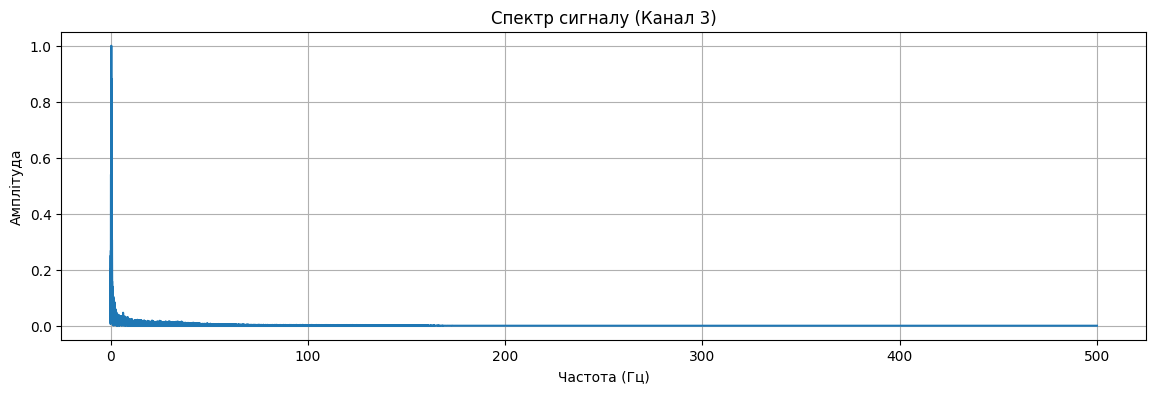

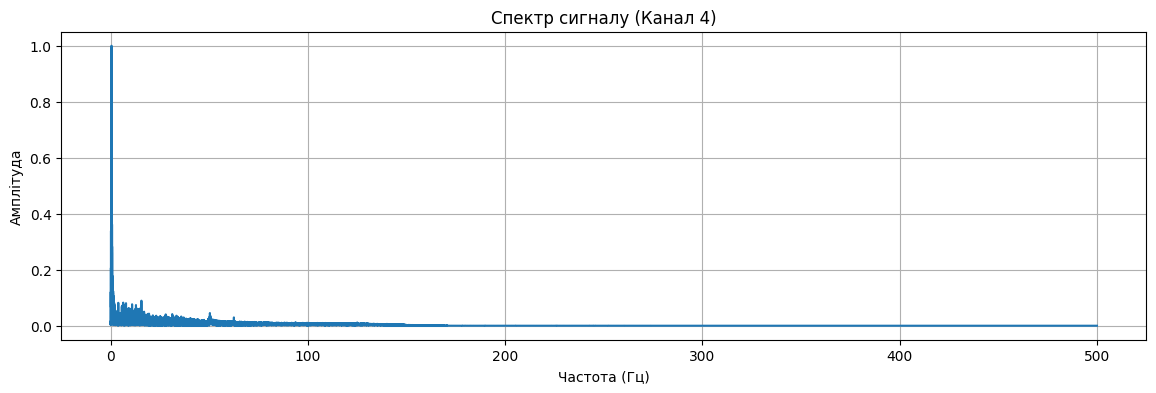

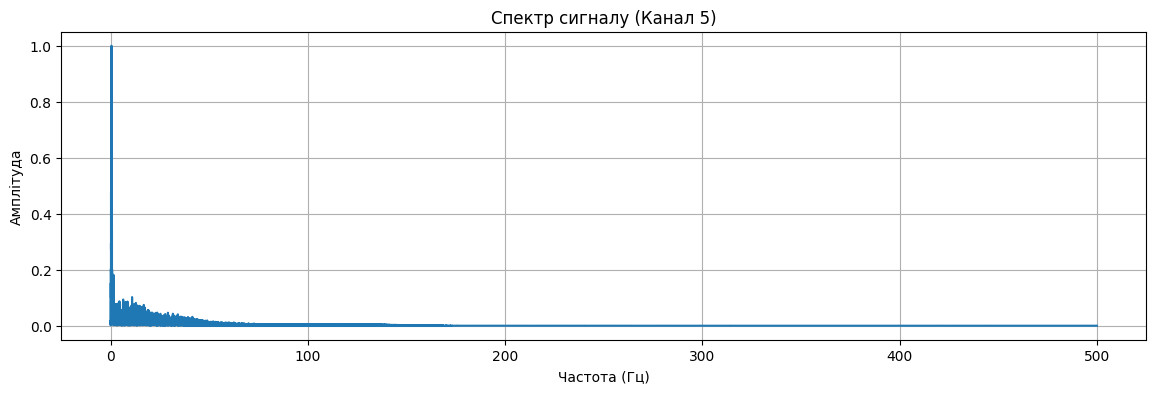

Файл: r10.edf, Каналів: 5


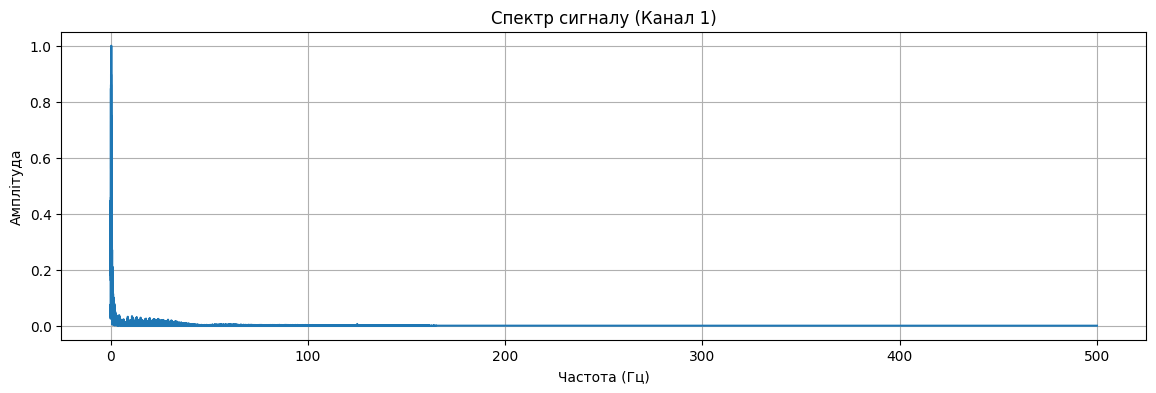

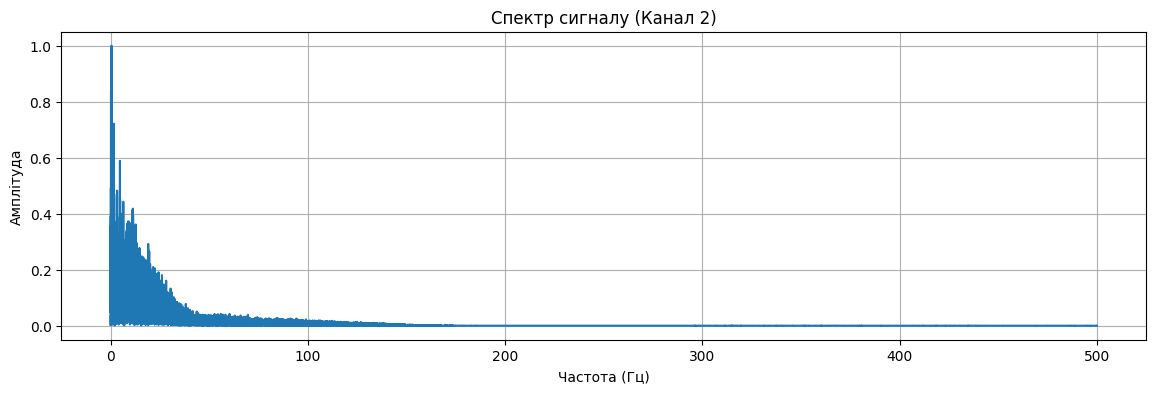

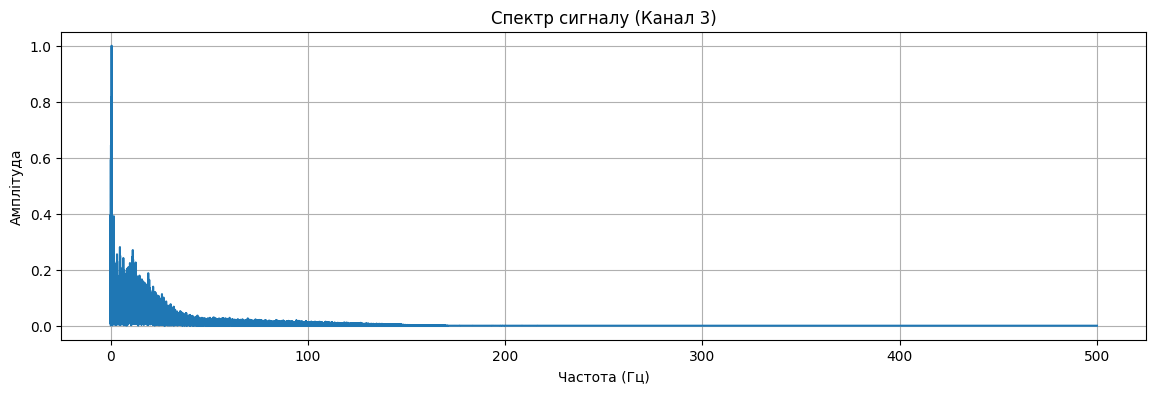

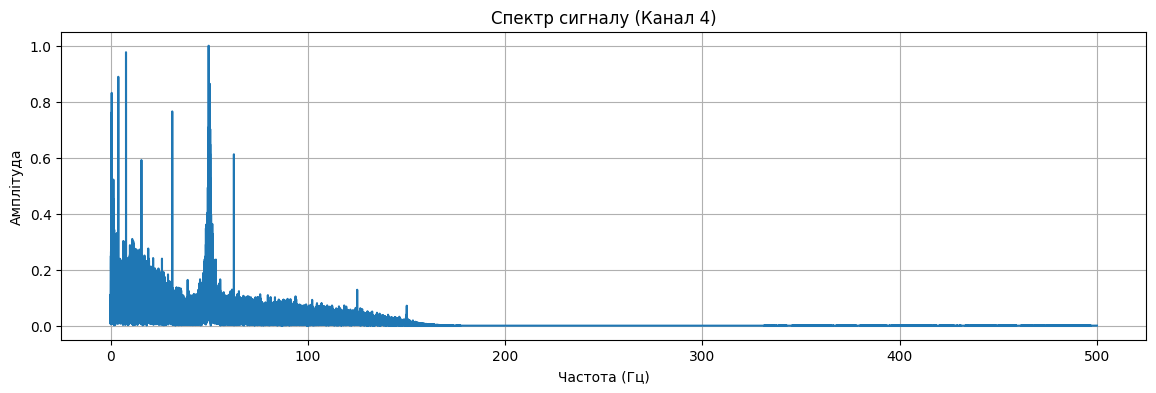

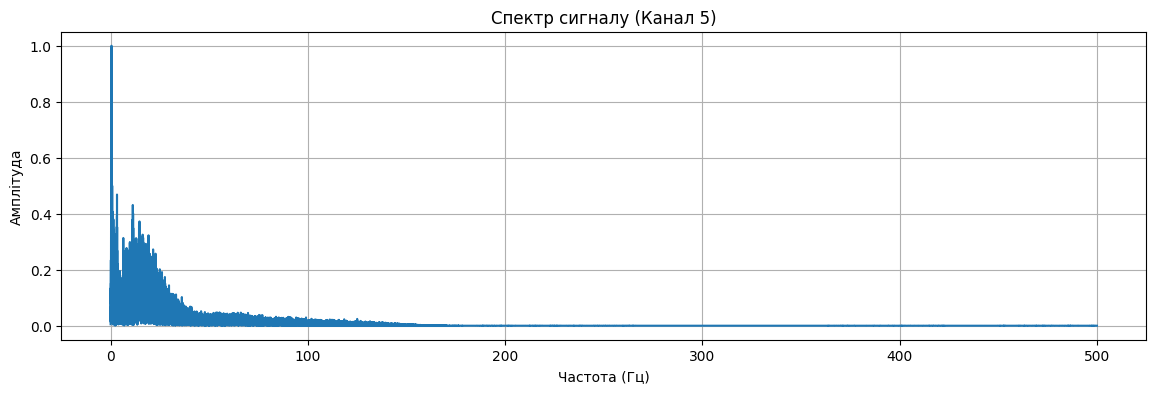

In [5]:
folder_path = "./abdominal-and-direct-fetal-ecg-database-1.0.0/abdominal-and-direct-fetal-ecg-database-1.0.0"

for file_name in os.listdir(folder_path):
    if file_name.endswith(".edf"):
        edf_file_path = os.path.join(folder_path, file_name)
        edf_file = pyedflib.EdfReader(edf_file_path)
        num_channels = edf_file.signals_in_file
        print(f"Файл: {file_name}, Каналів: {num_channels}")
        
        for i in range(num_channels):
            signal = edf_file.readSignal(i)

            fs = 1000
            n = len(signal)
            freqs = np.fft.fftfreq(n, 1/fs)
            spectrum = np.fft.fft(signal)
            spectrum_normalized = np.abs(spectrum) / np.max(np.abs(spectrum))
            
            plt.figure(figsize=(14, 4))
            plt.plot(freqs[:n//2], np.abs(spectrum_normalized)[:n//2])
            plt.title(f"Спектр сигналу (Канал {i+1})")
            plt.xlabel('Частота (Гц)')
            plt.ylabel('Амплітуда')
            plt.grid(True)
            plt.show()

        edf_file.close()

## 3

ICA:
Independent Component Analisys, Незалежний компонентний аналіз - техніка, яка дозволє відокремлювати та ідентифікувати базові незалежні джерела в багатовимірному наборі даних.

Ця техніка аналізу важлива, тому що вона дозволяє зрозуміти приховану структуру набору даних, її можна використовувати в різних програмах: від обробки сигналів, до фінансів. Це - алгоритм неконтрольованого навчання у сфері штучного інтелекту, суть якого - розділити багатовимірний сигнал на додаткові підкомпоненти, щоб відсіяти непотрібні шуми та сигнали, які викривлюють той сигнал, який нас цікавить.

Працює цей алгоритм за такою формулою:

\begin{equation}
S = A^{-1} \cdot x
\end{equation},  де

 - S - незалежні сигнали, які ми хочемо отримати
 - A - матриця змішування материнських сигналів
 - x - виміряні сигнали
  
Матриця $A$ складається з трьох складових частин, які є результатом множення між різними факторами:

$$
A^{-1} = (U^T \Sigma^{-1} V) = 
\begin{cases}
U^T: \text{пошук кута із максимальною дисперсією для повороту} \\
\Sigma^{-1}: \text{пошук масштабування головних компонент} \\
V: \text{кінцевий поворот матриці для відновлення сигналу}
\end{cases}
$$



In [2]:
def calculate_snr(original_signal, cleaned_signal):
    signal_power = np.mean(cleaned_signal**2)
    noise = original_signal - cleaned_signal
    noise_power = np.mean(noise**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

Файл: r01.edf, Каналів: 5


c:\Users\katja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


SNR для файлу r01.edf: -87.52 дБ


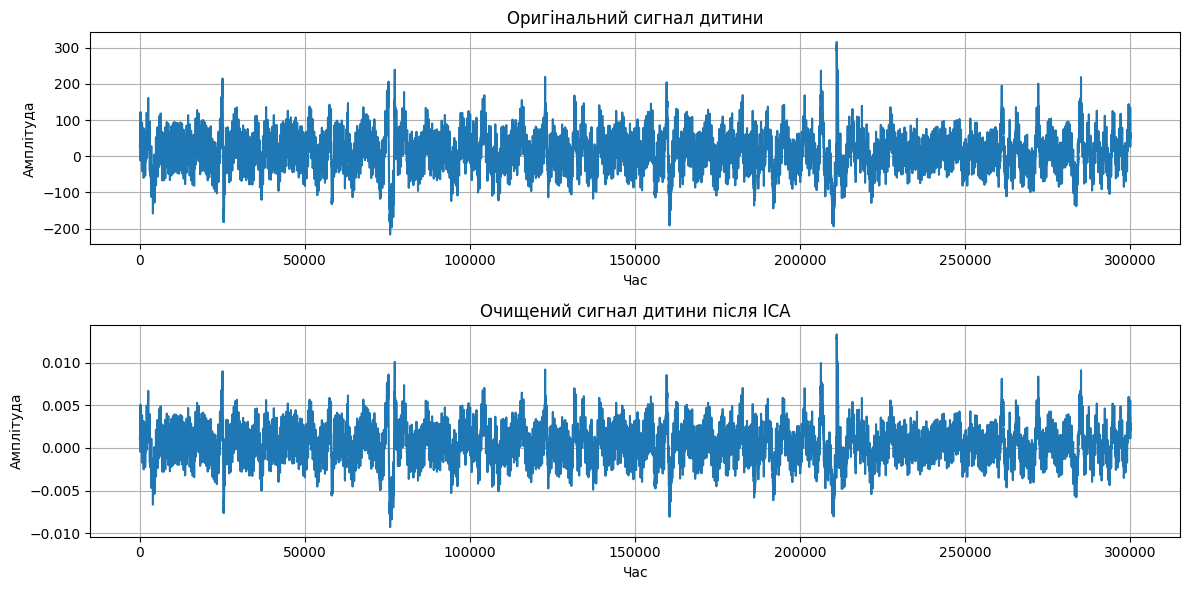

Файл: r04.edf, Каналів: 5


c:\Users\katja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


SNR для файлу r04.edf: -93.24 дБ


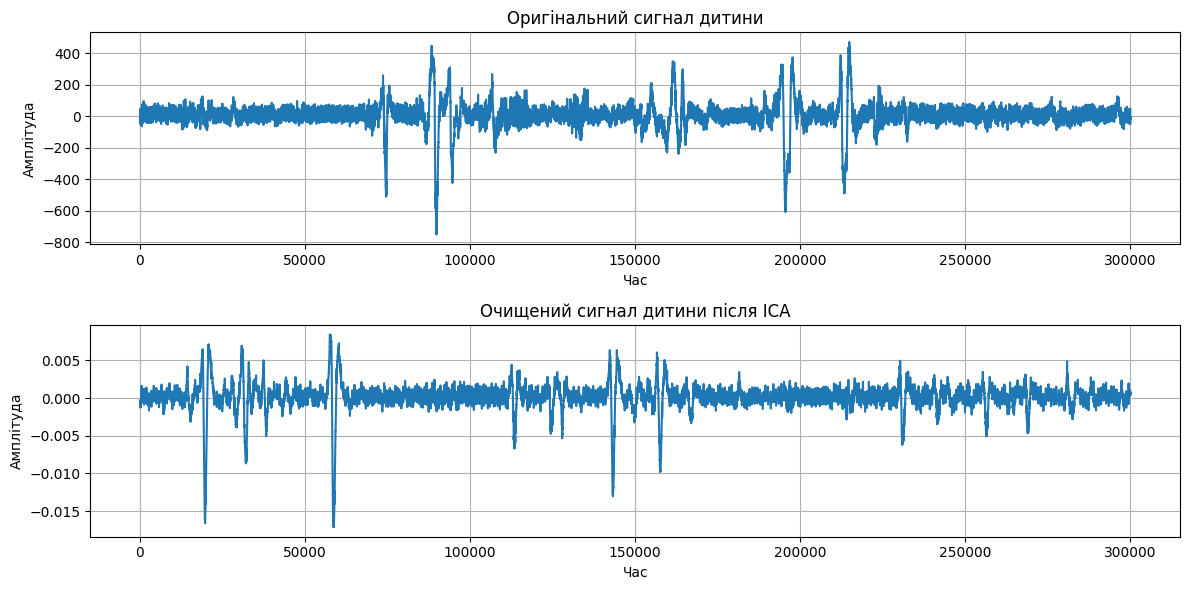

Файл: r07.edf, Каналів: 5


c:\Users\katja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


SNR для файлу r07.edf: -86.20 дБ


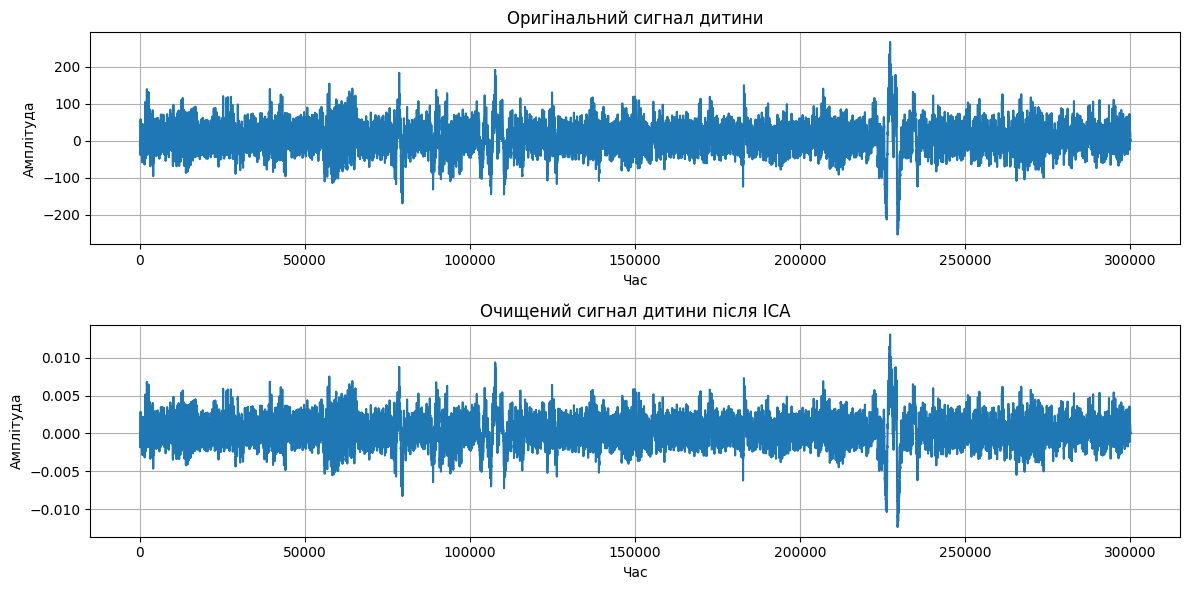

Файл: r08.edf, Каналів: 5


c:\Users\katja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


SNR для файлу r08.edf: -91.64 дБ


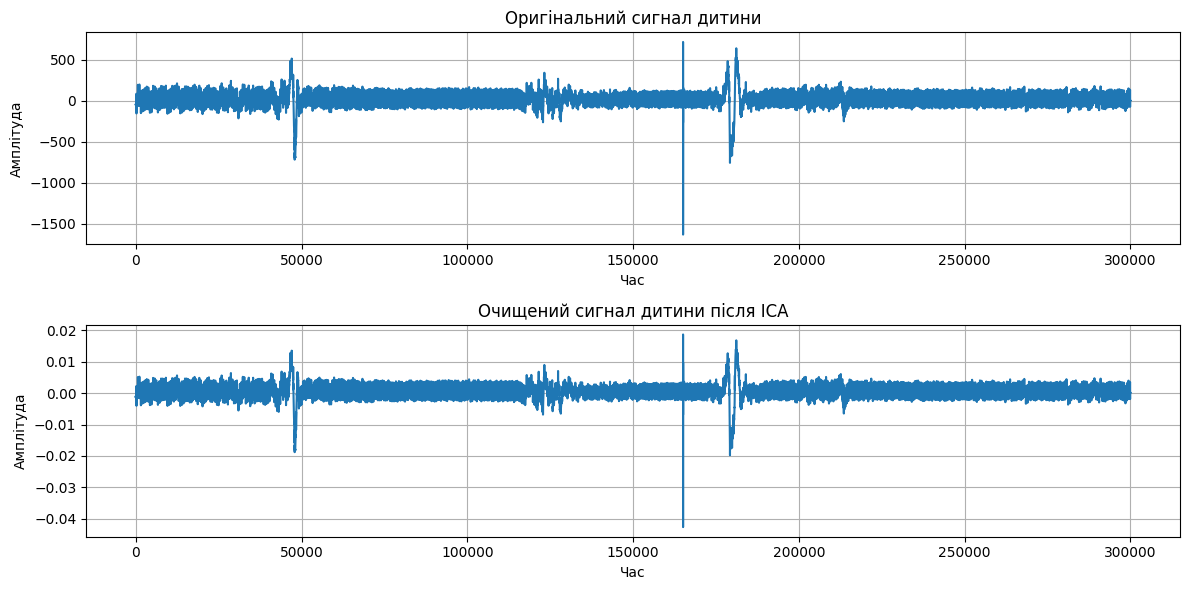

Файл: r10.edf, Каналів: 5


c:\Users\katja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


SNR для файлу r10.edf: -97.80 дБ


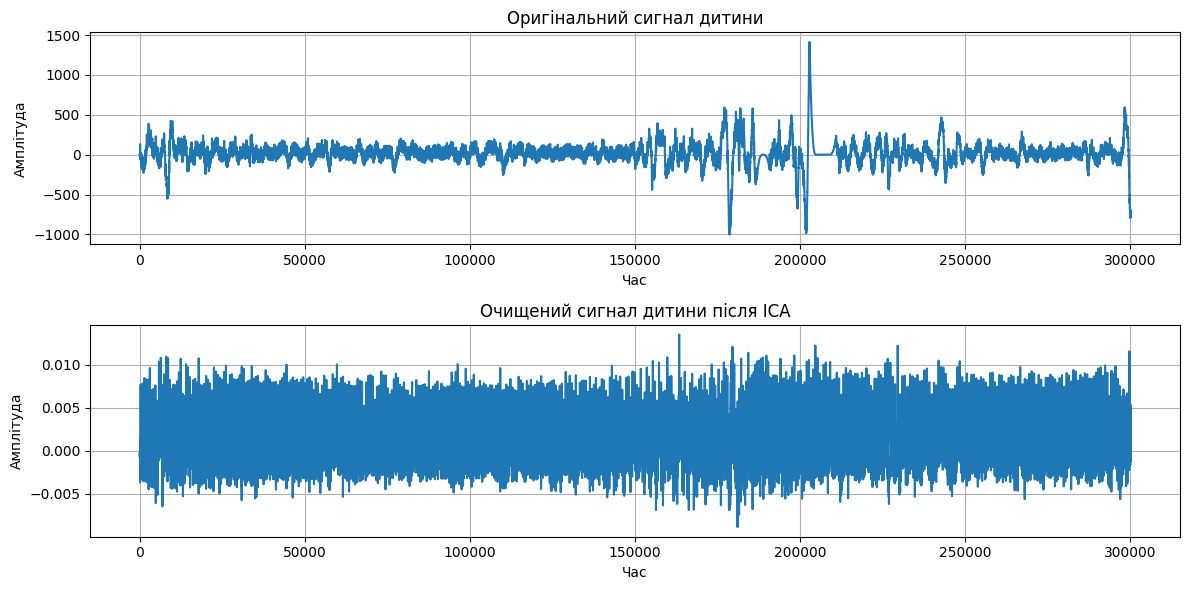

In [5]:
folder_path = "./abdominal-and-direct-fetal-ecg-database-1.0.0/abdominal-and-direct-fetal-ecg-database-1.0.0"

for file_name in os.listdir(folder_path):
    if file_name.endswith(".edf"):
        edf_file_path = os.path.join(folder_path, file_name)
        edf_file = pyedflib.EdfReader(edf_file_path)
        num_channels = edf_file.signals_in_file
        print(f"Файл: {file_name}, Каналів: {num_channels}")

        if num_channels == 5:
            signals = []
            for i in range(num_channels):
                signals.append(edf_file.readSignal(i))
                
            signals = np.array(signals)
            ica = FastICA(n_components=2)
            separated_signals = ica.fit_transform(signals.T)
            original_signal_child = signals[0]
            
            snr = calculate_snr(original_signal_child, separated_signals[:, 0])
            print(f"SNR для файлу {file_name}: {snr:.2f} дБ")
            
            plt.figure(figsize=(12, 6))

            plt.subplot(2, 1, 1)
            plt.plot(original_signal_child)
            plt.title("Оригінальний сигнал дитини")
            plt.xlabel('Час')
            plt.ylabel('Амплітуда')
            plt.grid(True)

            plt.subplot(2, 1, 2)
            plt.plot(separated_signals[:, 0])
            plt.title("Очищений сигнал дитини після ICA")
            plt.xlabel('Час')
            plt.ylabel('Амплітуда')
            plt.grid(True)

            plt.tight_layout()
            plt.show()
            
        edf_file.close()

## 4

SVD: 
Singular Value Decomposition, Сингулярне Розкладання - алгоритм узагальнення розкладу матриці на будь-яку матрицю, без припущення, що матриця квадратна.

Загальна формула SVD така:

$$
M = U\Sigma V^T,
$$
де:

- M — вихідна матриця, яку ми хочемо розкласти.
- U — ліва сингулярна матриця (стовпці — ліві сингулярні вектори). Стовпці U містять власні вектори матриці MM^T.
- V — права сингулярна матриця (стовпці — праві сингулярні вектори). Стовпці V містять власні вектори матриці M^T * M.
- Σ — діагональна матриця, що містить сингулярні власні значення.

SVD працює за такими алгоритмом:
- Зміна базису зі стандартного на бази V (за допомогою V^T)
- Застосування перетворення, яке описується матрицею Σ. Це масштабує наш вектор в базисі V.
- Зміна базису з V на U. Оскільки наша початкова матриця не є квадратною, то ми не можемо повернутись до початкового стандартного базису.

Файл: r01.edf, Каналів: 5
SNR для файлу r01.edf: -136.00 дБ


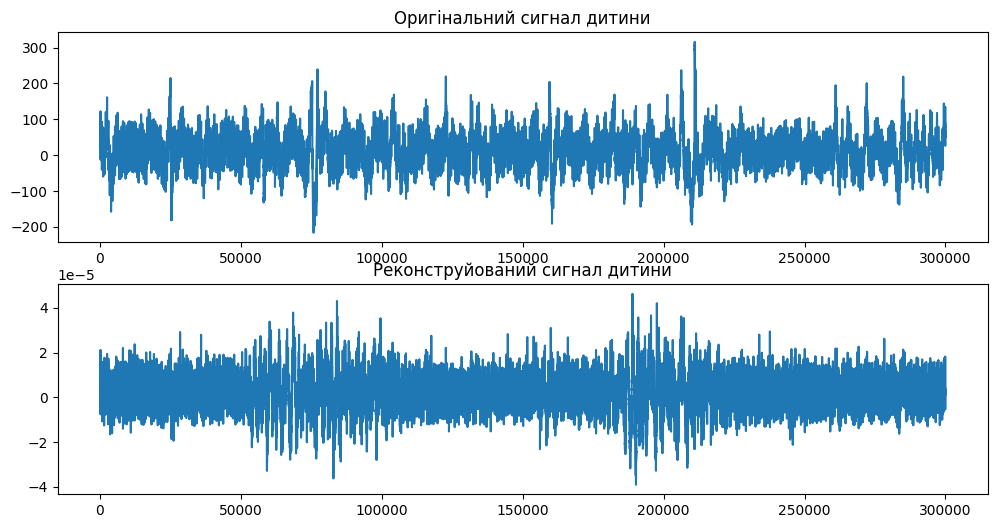

Файл: r04.edf, Каналів: 5
SNR для файлу r04.edf: -138.85 дБ


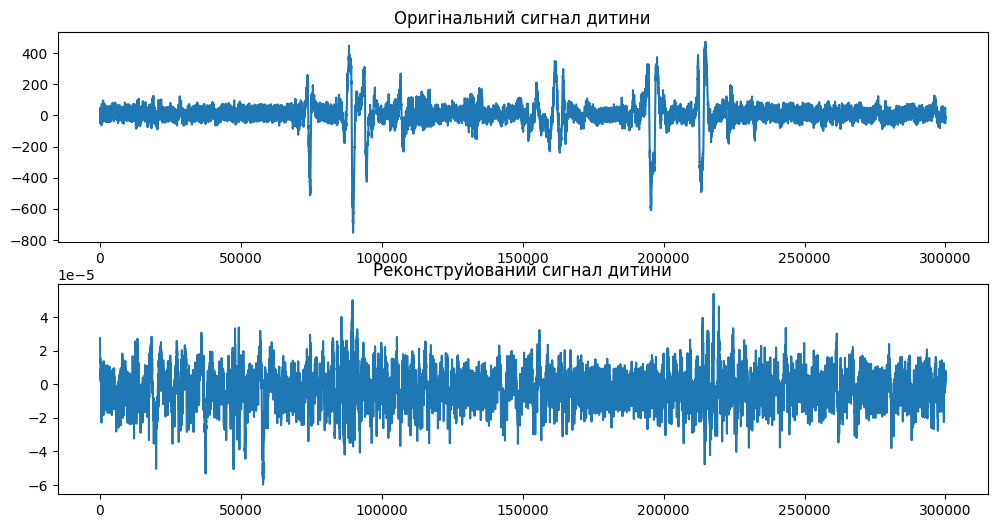

Файл: r07.edf, Каналів: 5
SNR для файлу r07.edf: -135.16 дБ


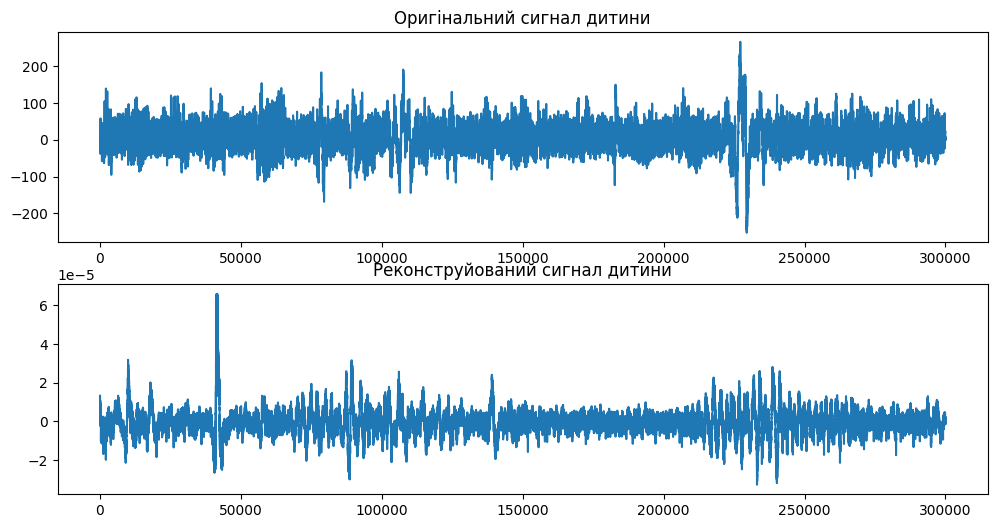

Файл: r08.edf, Каналів: 5
SNR для файлу r08.edf: -139.15 дБ


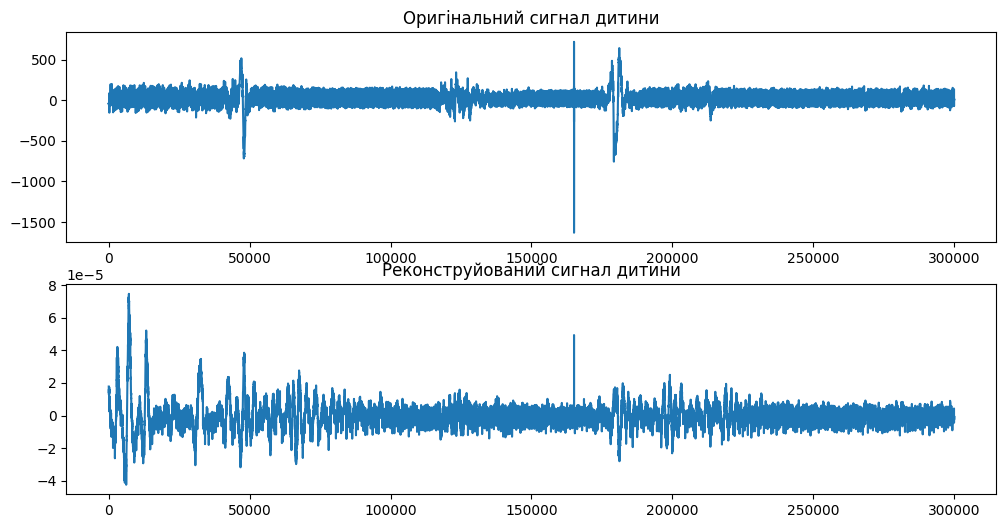

Файл: r10.edf, Каналів: 5
SNR для файлу r10.edf: -151.21 дБ


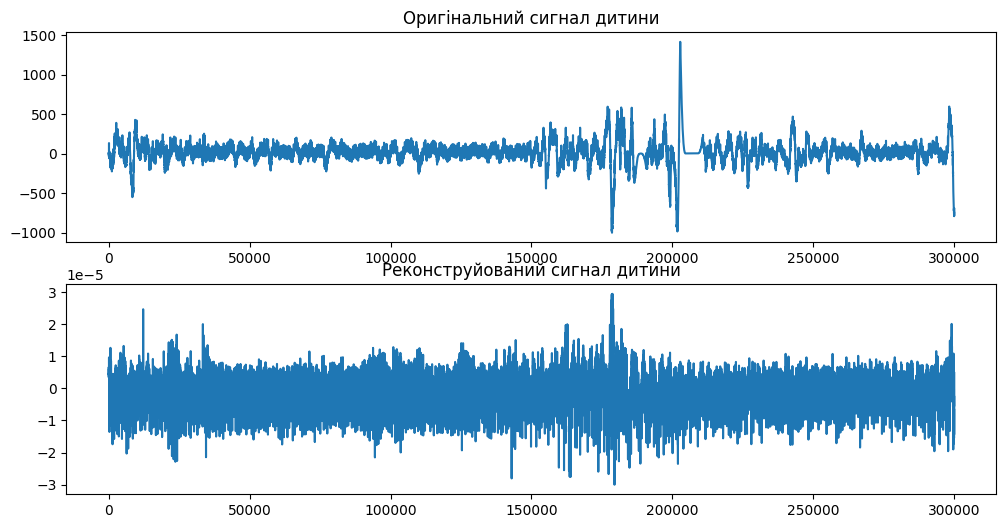

In [ ]:
folder_path = "./abdominal-and-direct-fetal-ecg-database-1.0.0/abdominal-and-direct-fetal-ecg-database-1.0.0"

for file_name in os.listdir(folder_path):
    if file_name.endswith(".edf"):
        edf_file_path = os.path.join(folder_path, file_name)

        with pyedflib.EdfReader(edf_file_path) as edf_file:
            num_channels = edf_file.signals_in_file
            print(f"Файл: {file_name}, Каналів: {num_channels}")

            signals = []
            for i in range(num_channels):
                signals.append(edf_file.readSignal(i))
            
            signals = np.array(signals)

            svd = TruncatedSVD(n_components=5)
            svd.fit(signals)
            components = svd.components_
            child_signal_component = components.T[0]

            reconstructed_child_signal = svd.inverse_transform([child_signal_component])
            reconstructed_child_signal = reconstructed_child_signal.flatten()

            snr = calculate_snr(signals[0, :], reconstructed_child_signal)
            print(f"SNR для файлу {file_name}: {snr:.2f} дБ")
            
            plt.figure(figsize=(12, 6))
            plt.subplot(2, 1, 1)
            plt.plot(signals[0, :])
            plt.title('Оригінальний сигнал дитини')

            plt.subplot(2, 1, 2)
            plt.plot(reconstructed_child_signal)
            plt.title('Реконструйований сигнал дитини')
            plt.show()

## 5

Фільтрація Савицього - Голея
  
Фільтр Савіцького-Голея, розроблений Абрахамом Савицьким і Марселем Дж. Голеєм у 1964 році, є цифровим фільтром, який широко використовується для згладжування та диференціації даних. Цей фільтр підтримує цілісність вихідного сигналу, зберігаючи його чіткі риси, що якраз корисно для нашого завдання. 
Цей фільтр працює за допомогою методу лінійних найменших квадратів, який згладжує точки, підбираючи послідовні підмножини суміжних точок даних поліномом низького ступеня. Завдяки цьому зберігаються основні особливості сигналу - його піки та спади. Він пересуває вікно фіксованого розміру над даними, підбираючи поліном до точок у цьому вікні. Значення полінома в центральній точці цього вікна береться як згладжене значення. Цей процес слід повторити для кожної точки в наборі даних, що призводить до згладженого сигналу. Цей фільтр застосовується для покращення SNR значення для всіх виміряних сигналів із наших файлів.


In [8]:
def twin_sgf(signal, window_size_1, poly_order_1, window_size_2, poly_order_2):
    filtered_signal_1 = savgol_filter(signal, window_length=window_size_1, polyorder=poly_order_1)
    filtered_signal_2 = savgol_filter(filtered_signal_1, window_length=window_size_2, polyorder=poly_order_2)
    return filtered_signal_2

Файл: r01.edf, Каналів: 5
SNR для файлу r01.edf: 11.00 дБ


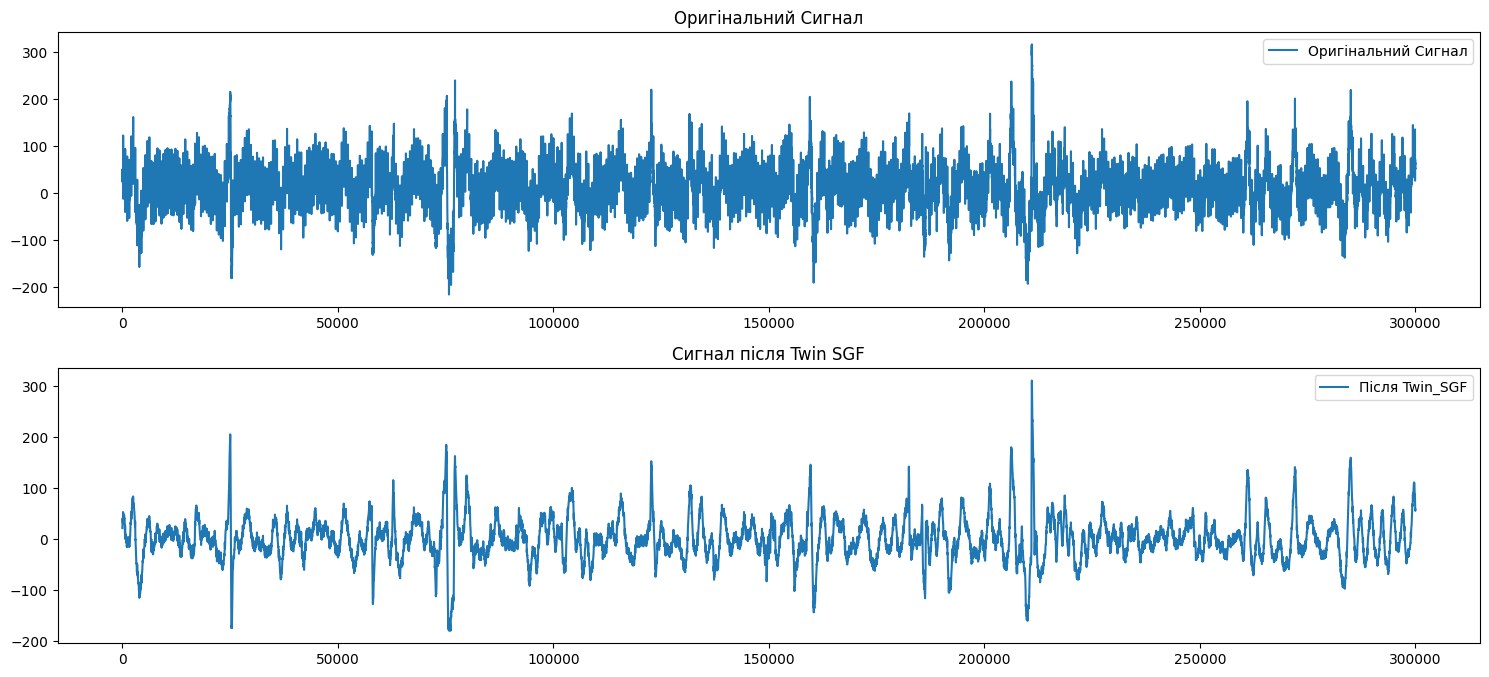

SNR для файлу r01.edf: 9.10 дБ


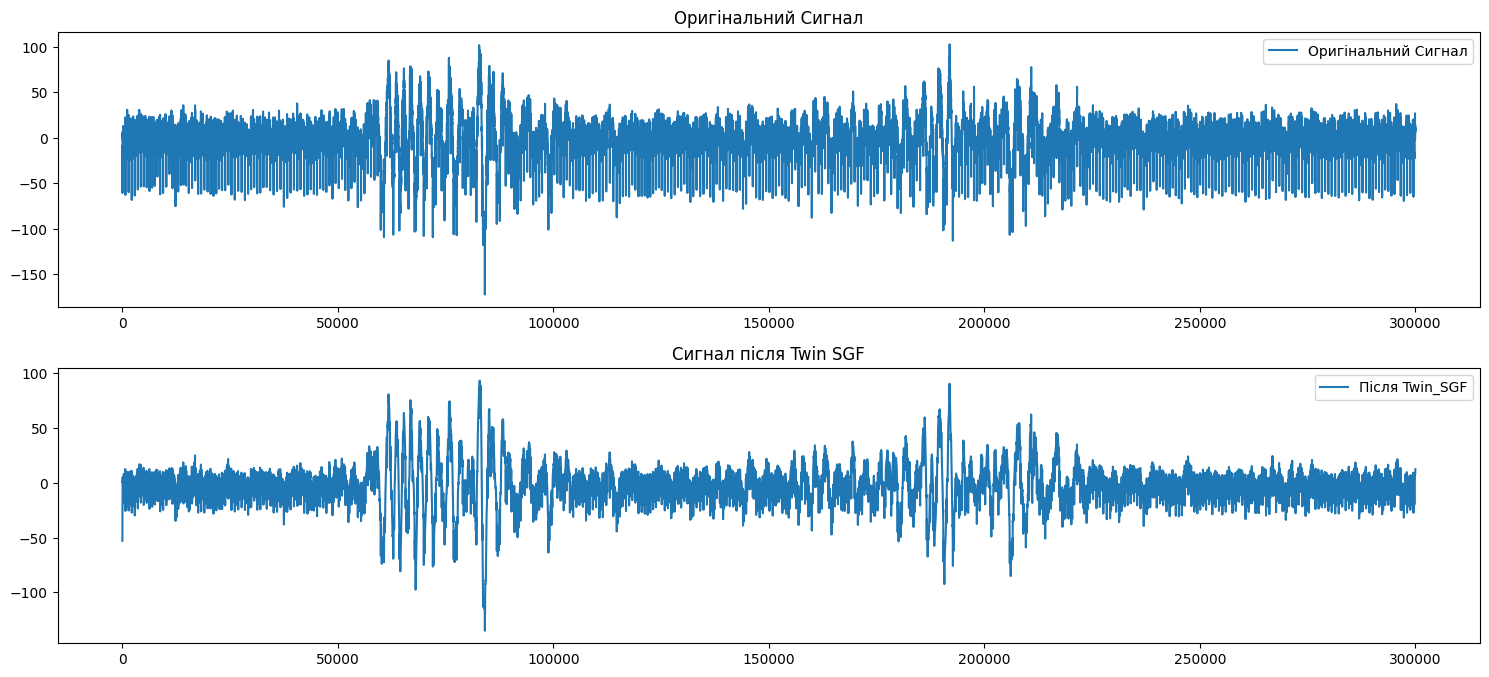

SNR для файлу r01.edf: 15.34 дБ


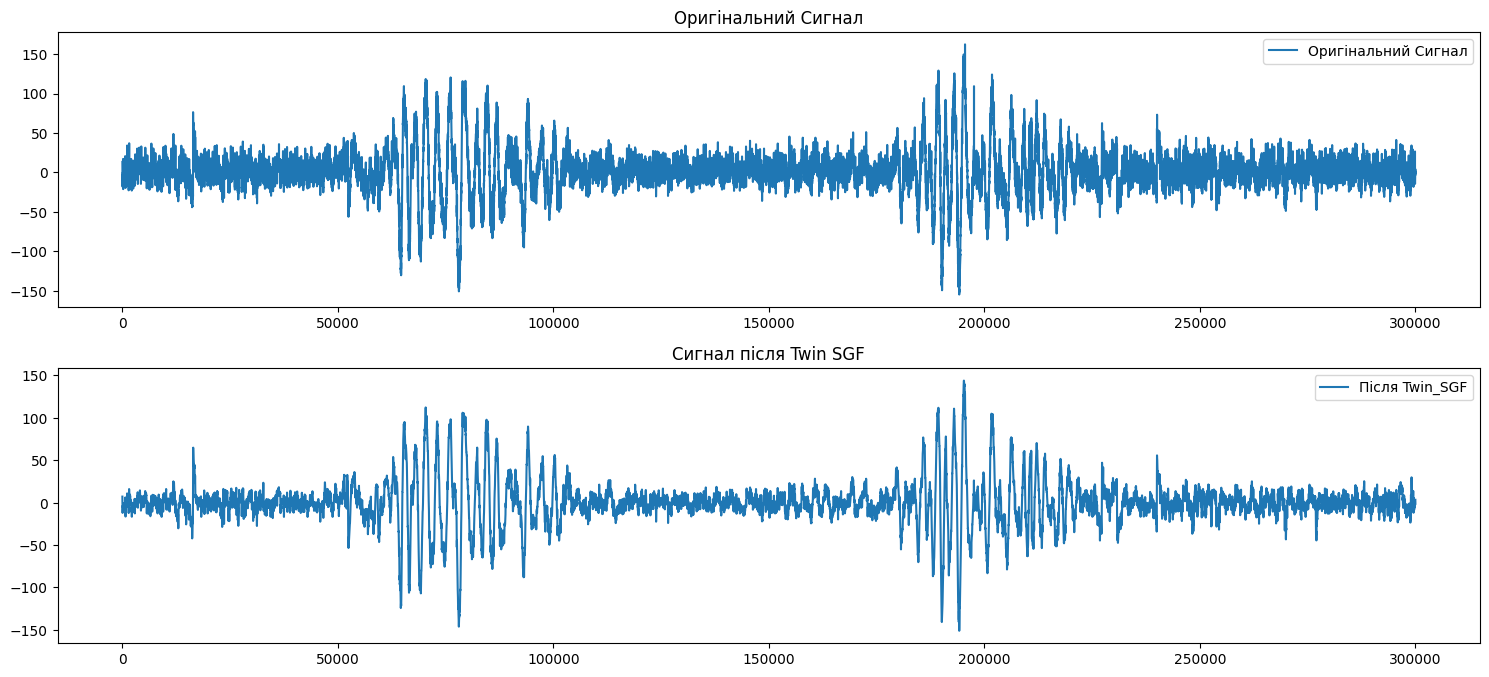

SNR для файлу r01.edf: 10.52 дБ


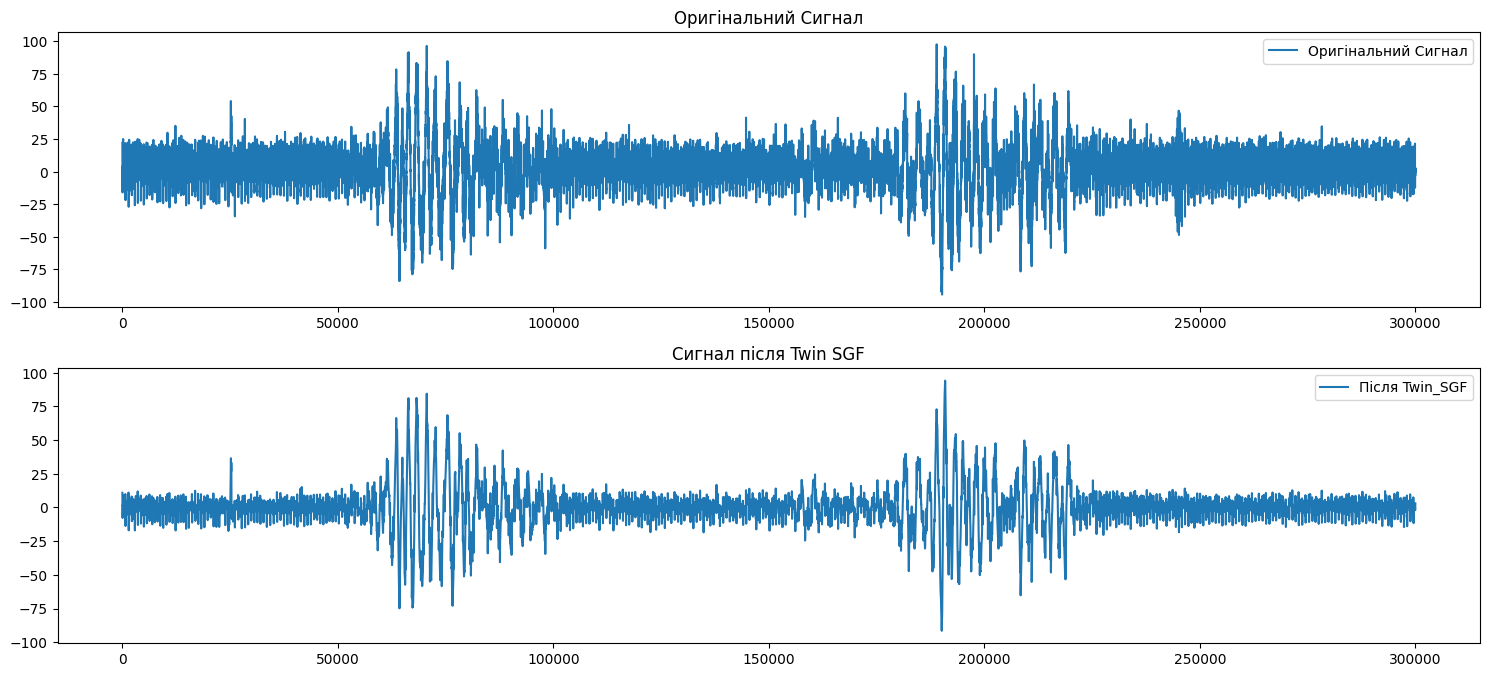

SNR для файлу r01.edf: 8.53 дБ


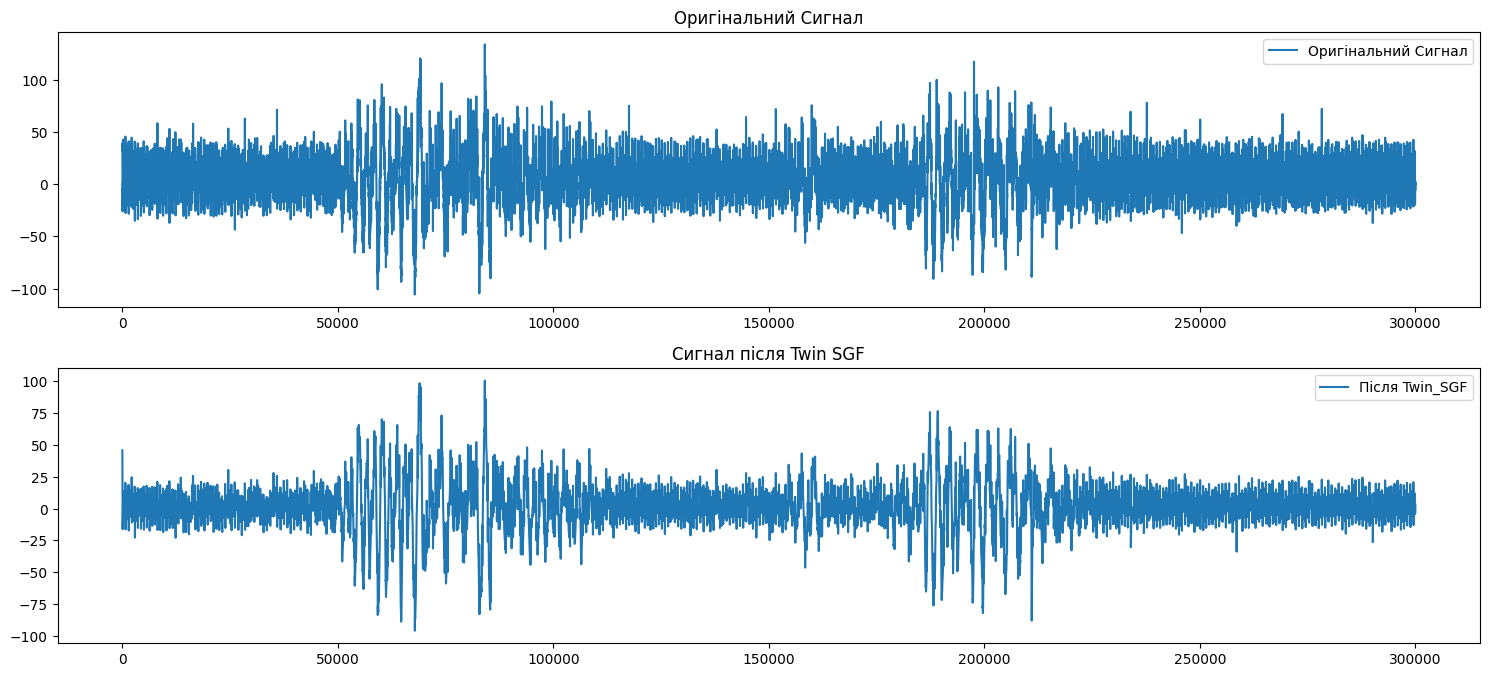

Файл: r04.edf, Каналів: 5
SNR для файлу r04.edf: 17.65 дБ


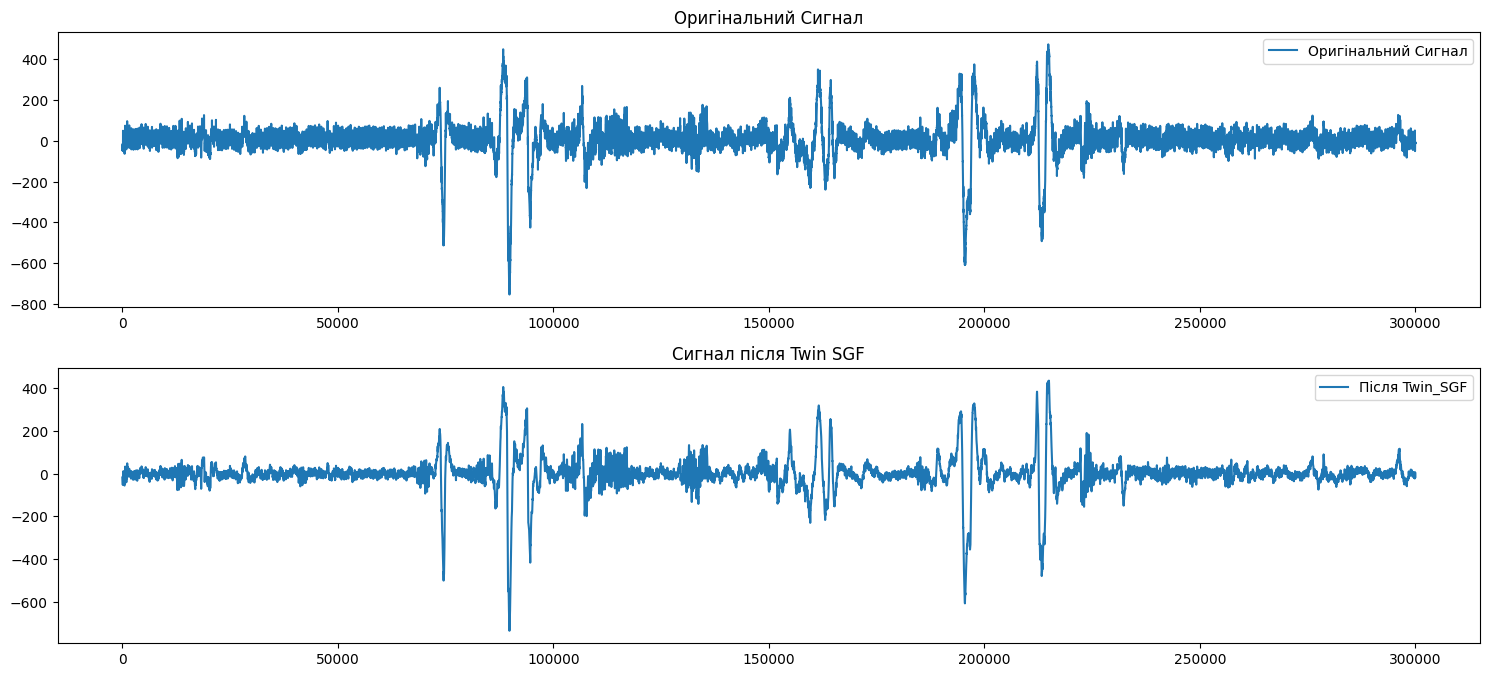

SNR для файлу r04.edf: 19.79 дБ


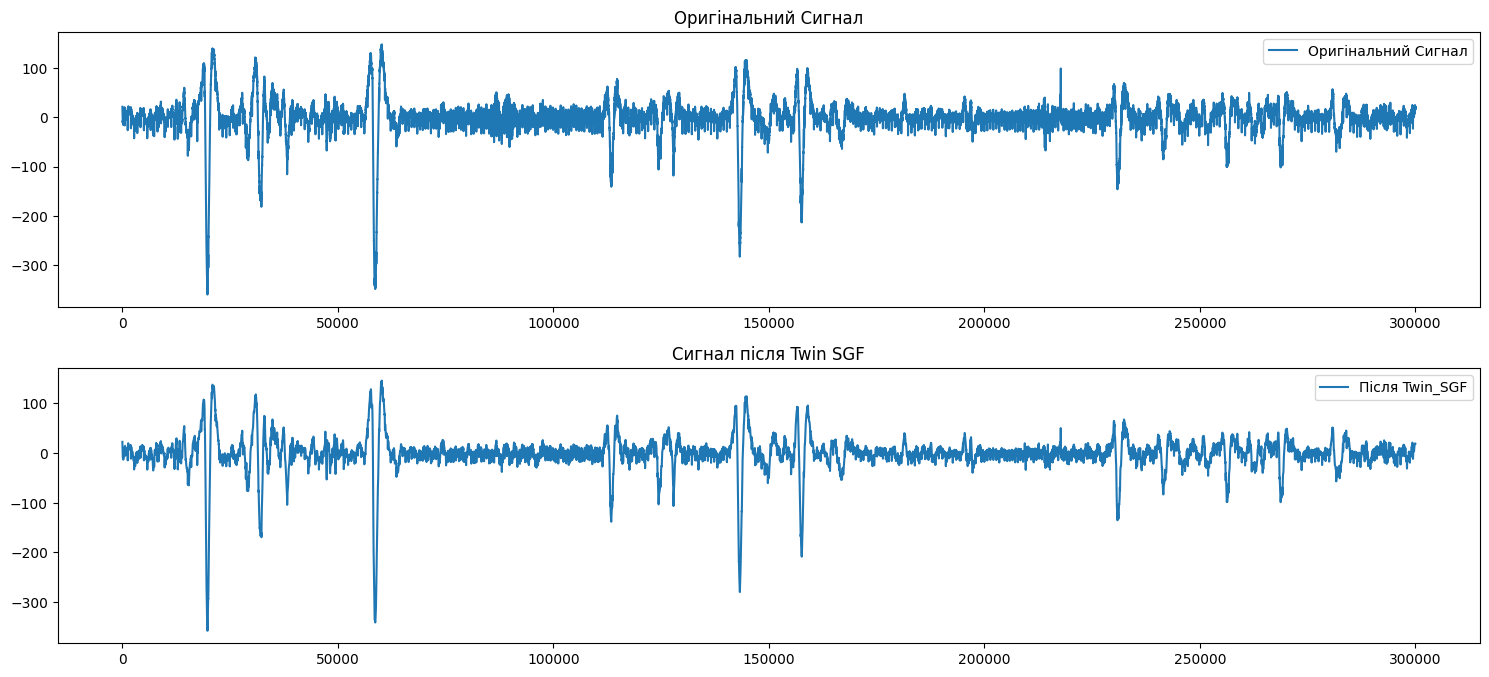

SNR для файлу r04.edf: 17.22 дБ


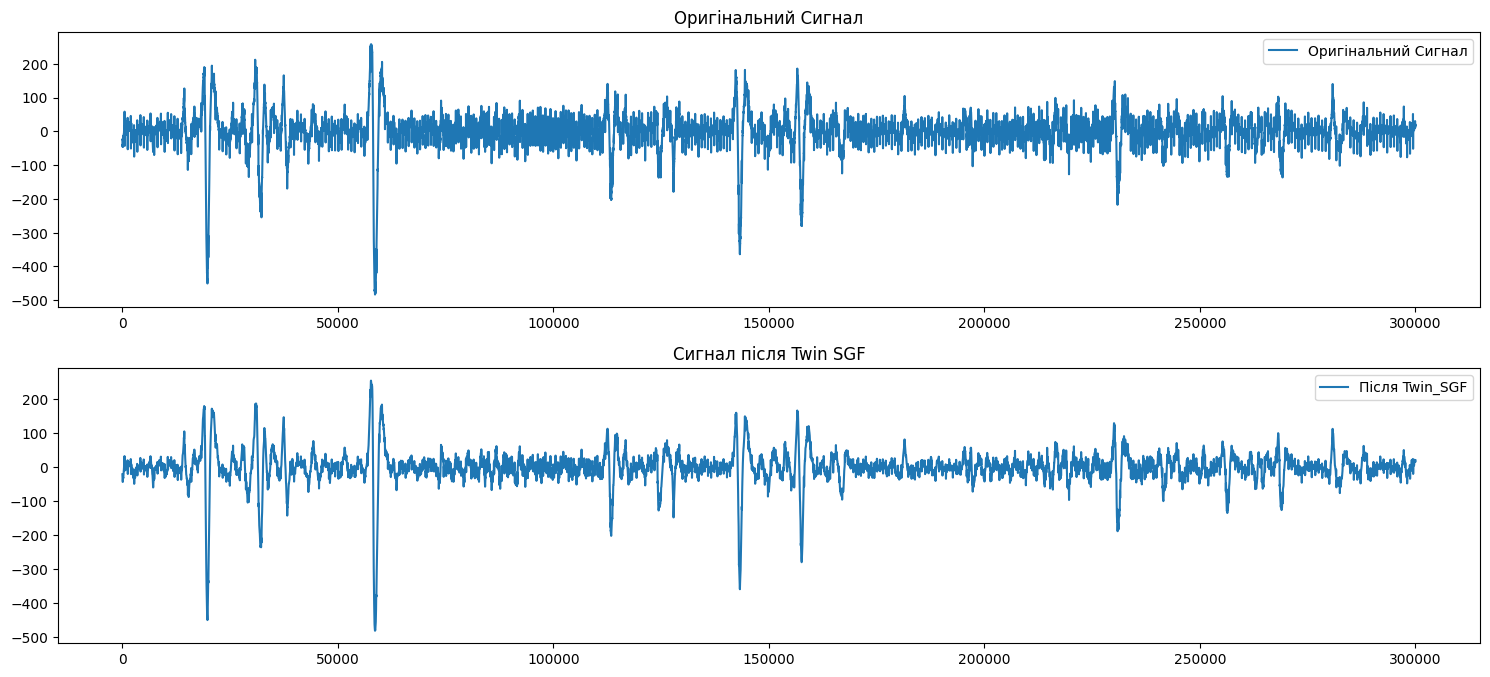

SNR для файлу r04.edf: 19.90 дБ


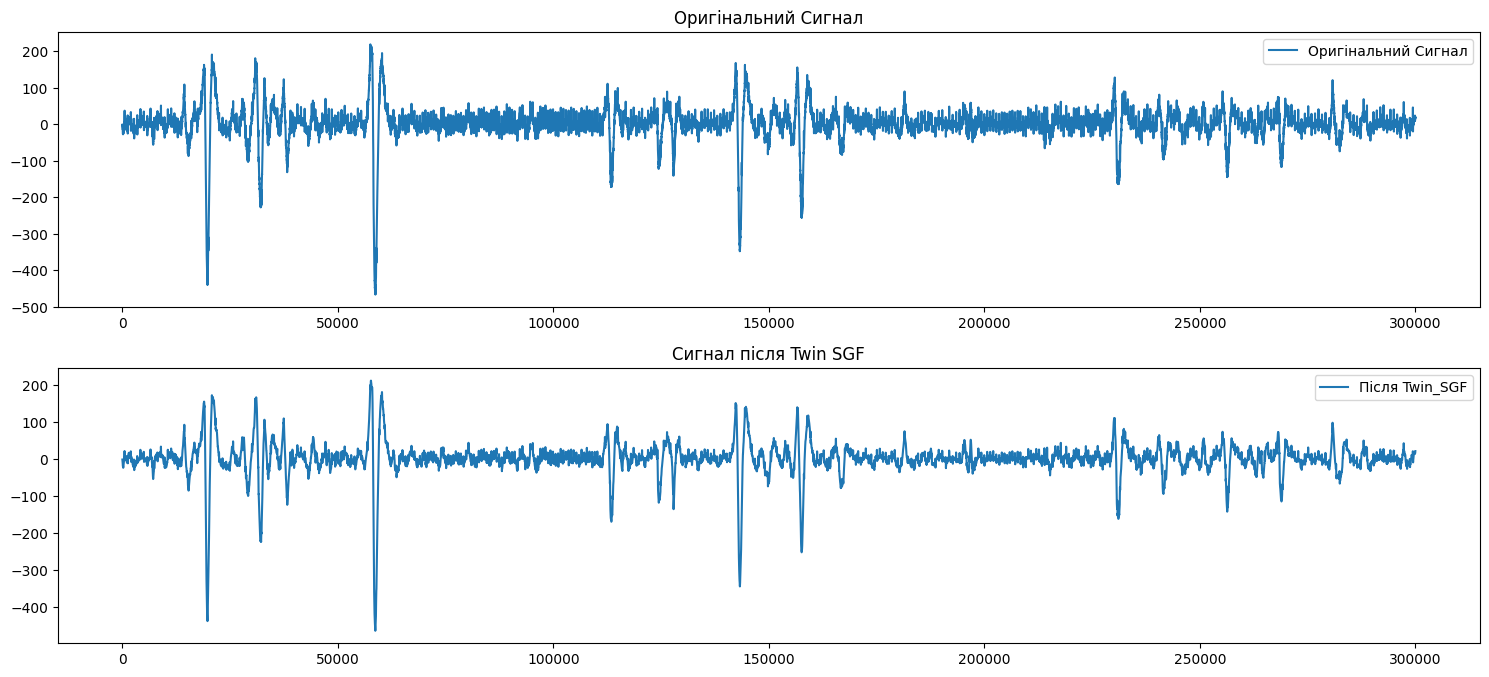

SNR для файлу r04.edf: 14.64 дБ


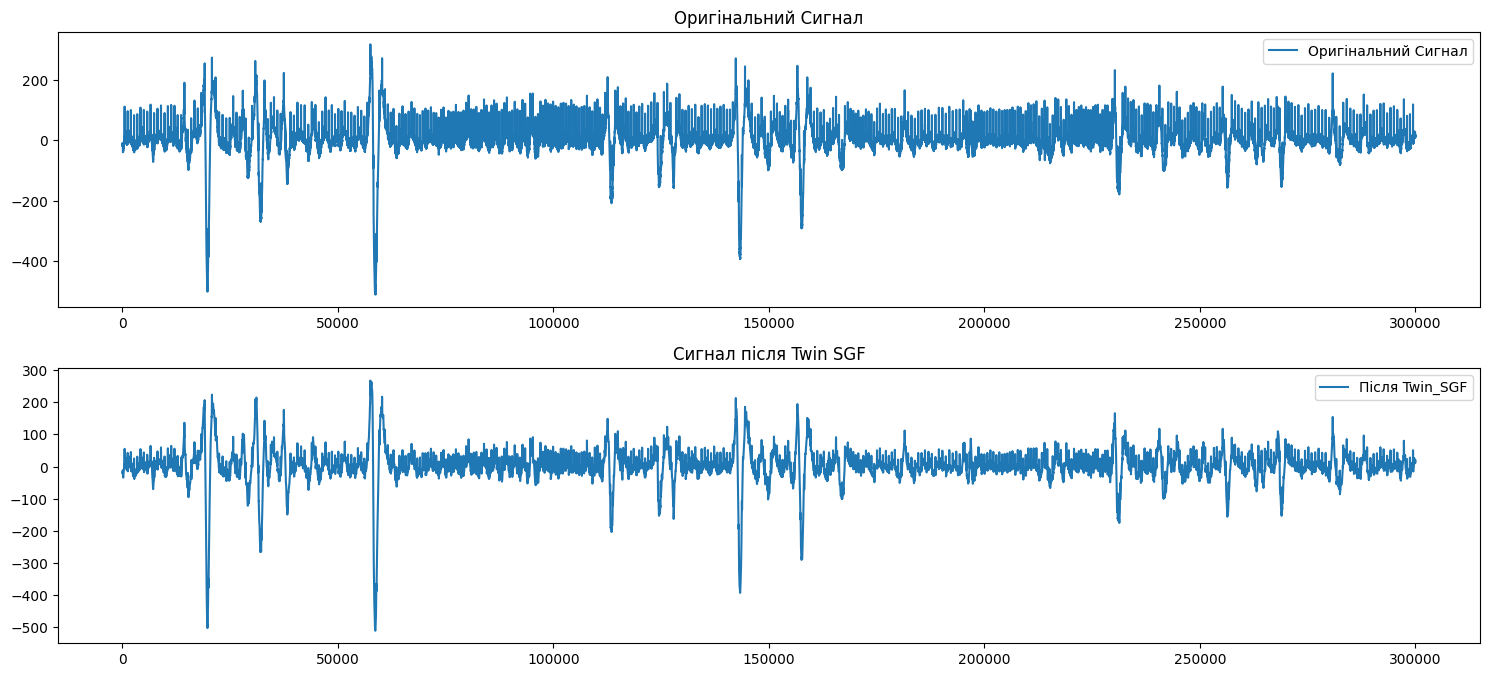

Файл: r07.edf, Каналів: 5
SNR для файлу r07.edf: 10.12 дБ


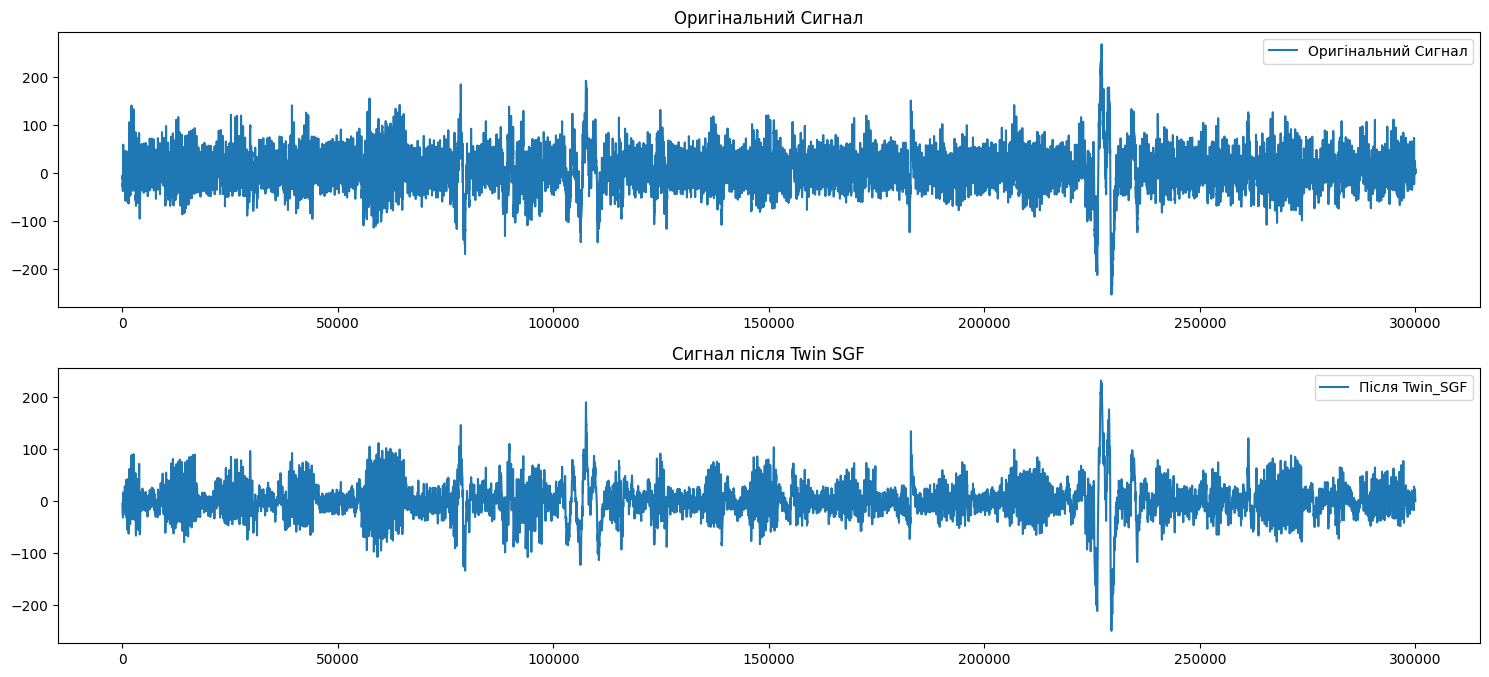

SNR для файлу r07.edf: 18.96 дБ


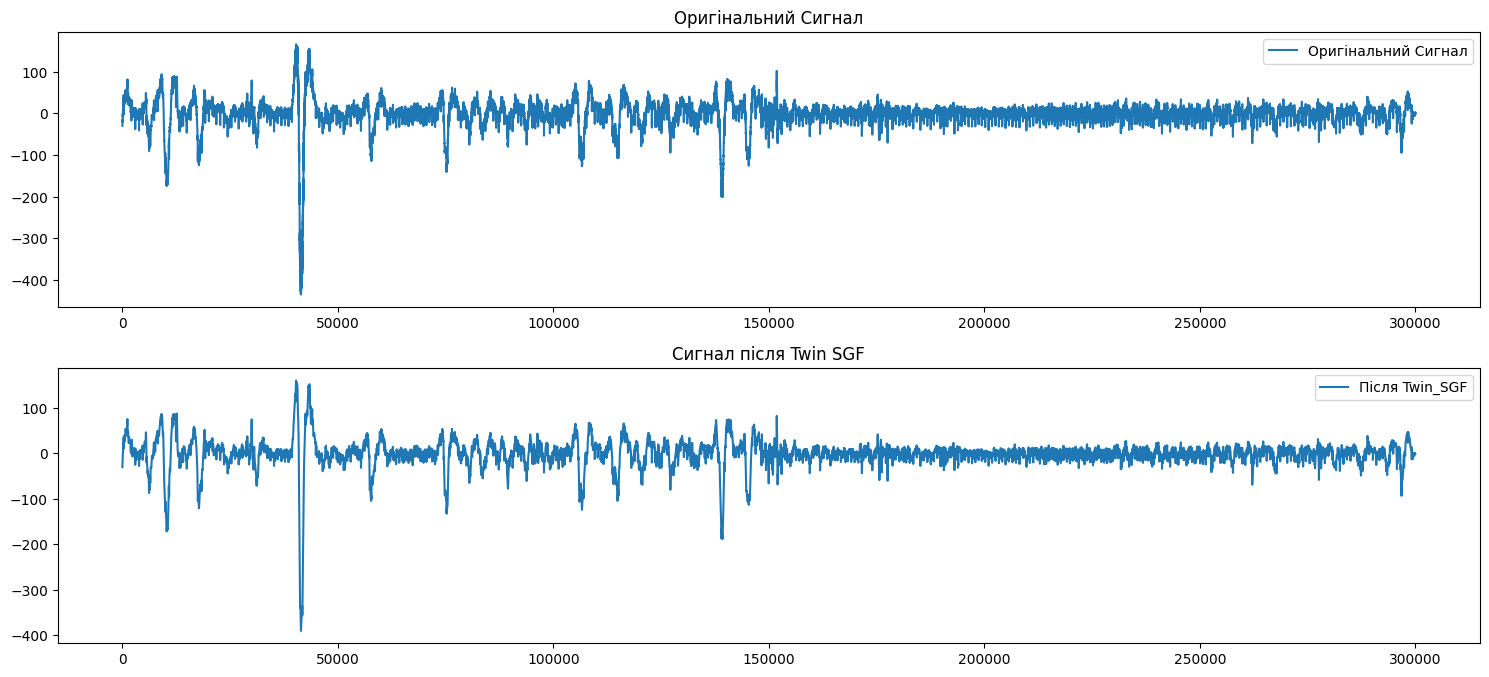

SNR для файлу r07.edf: 14.89 дБ


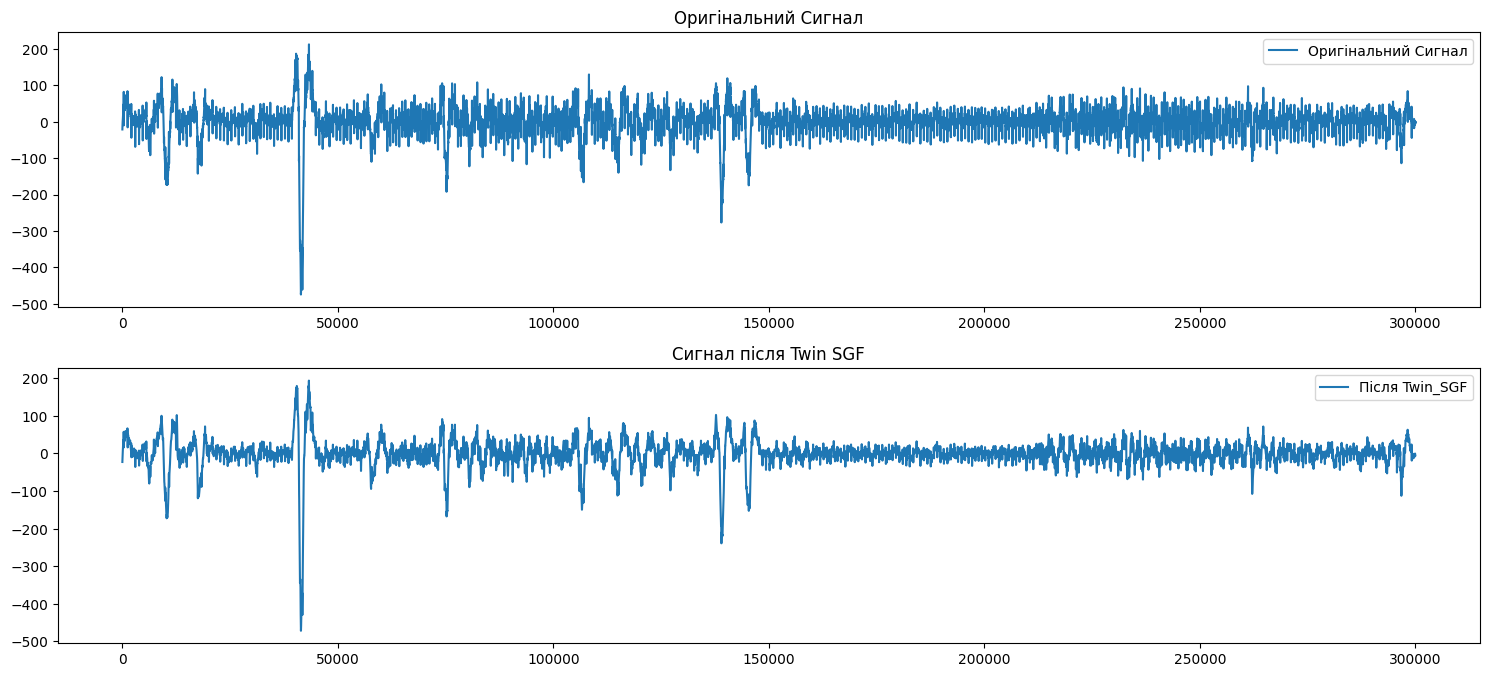

SNR для файлу r07.edf: 18.45 дБ


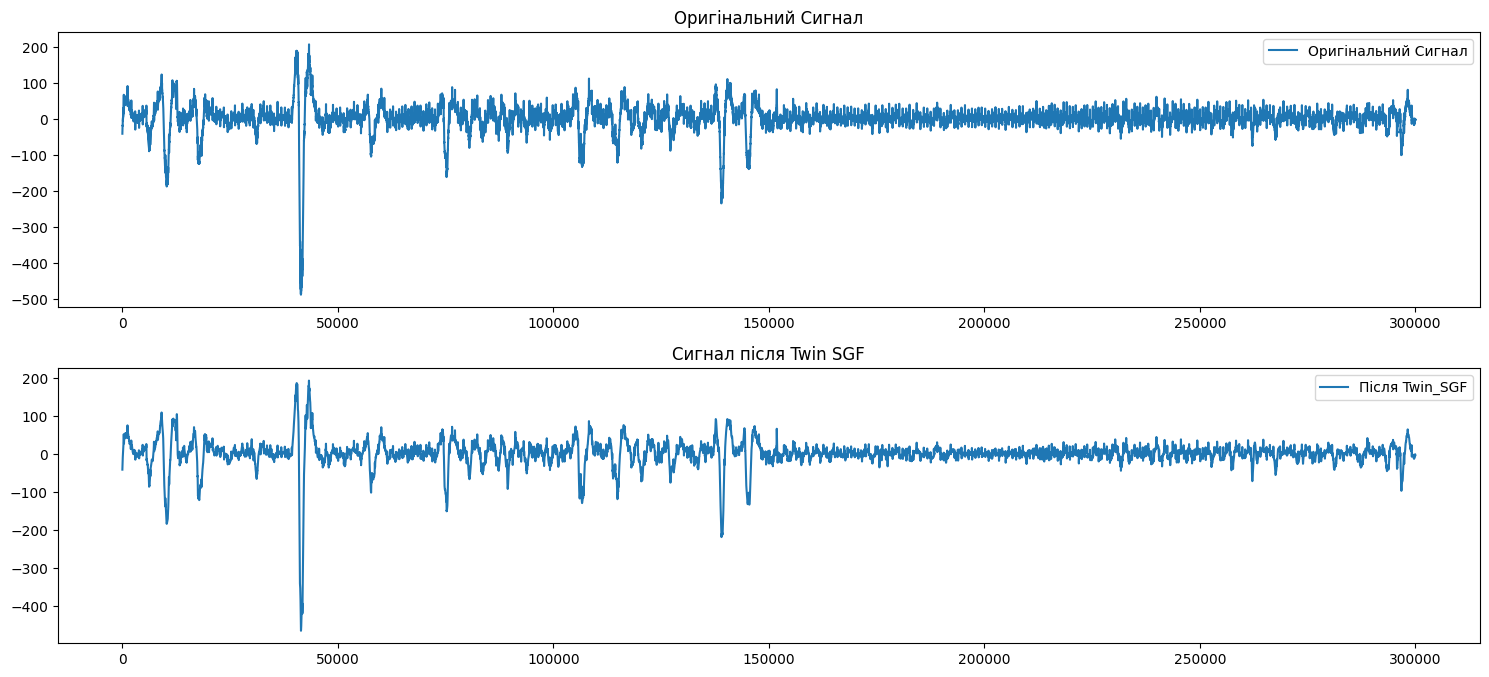

SNR для файлу r07.edf: 12.06 дБ


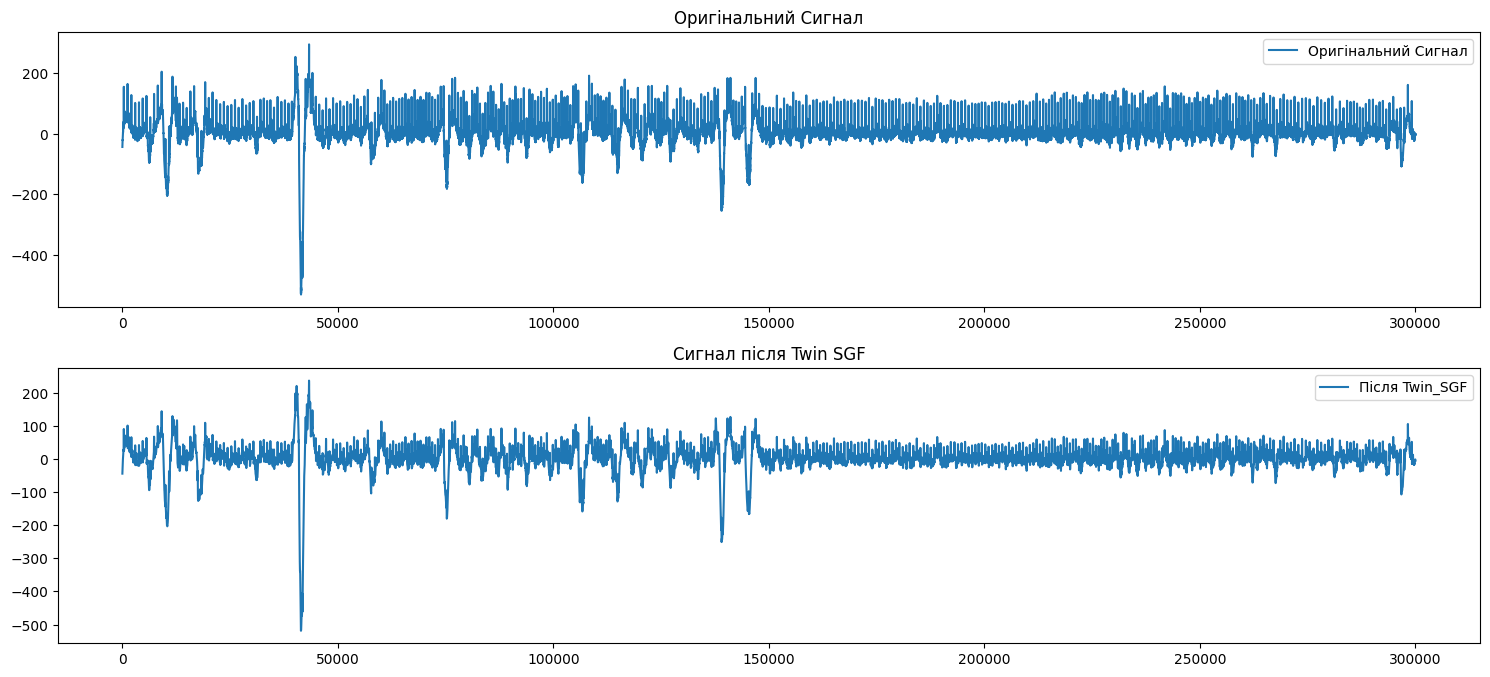

Файл: r08.edf, Каналів: 5
SNR для файлу r08.edf: 9.67 дБ


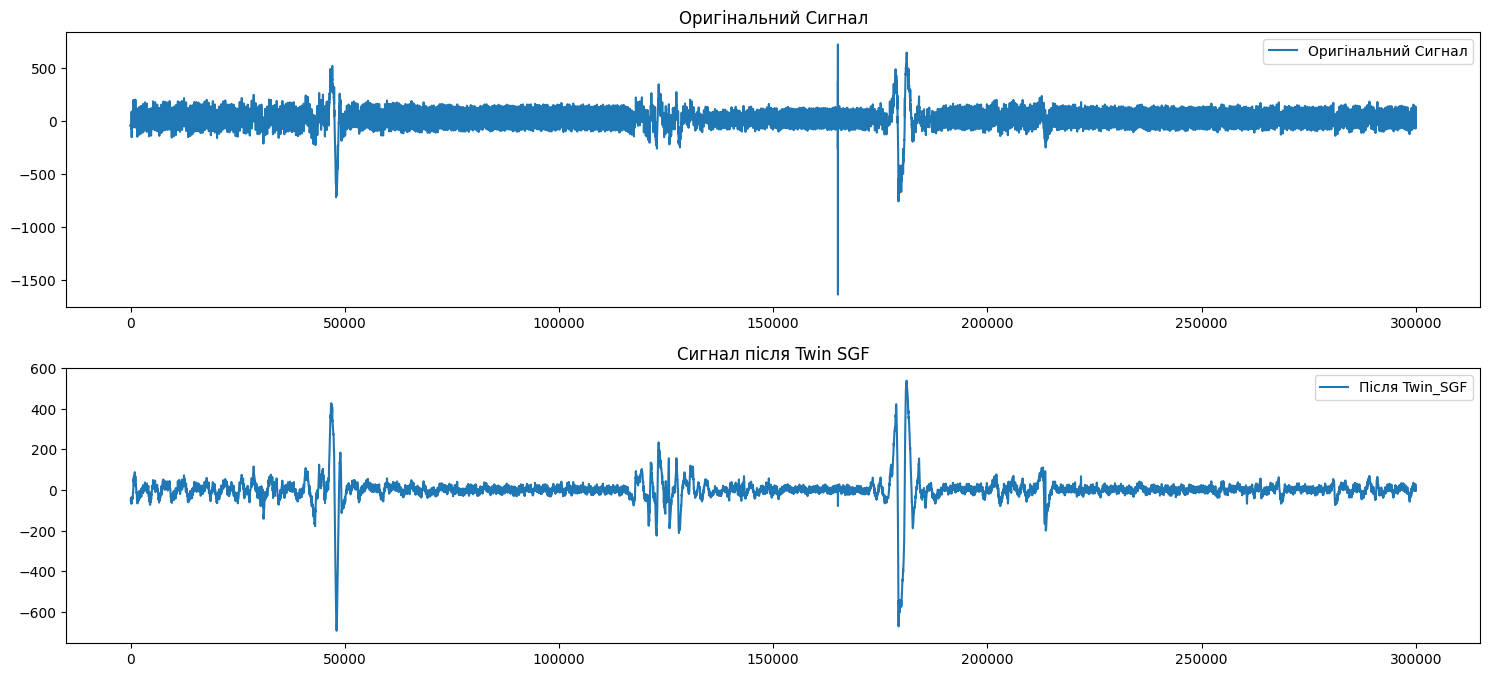

SNR для файлу r08.edf: 12.74 дБ


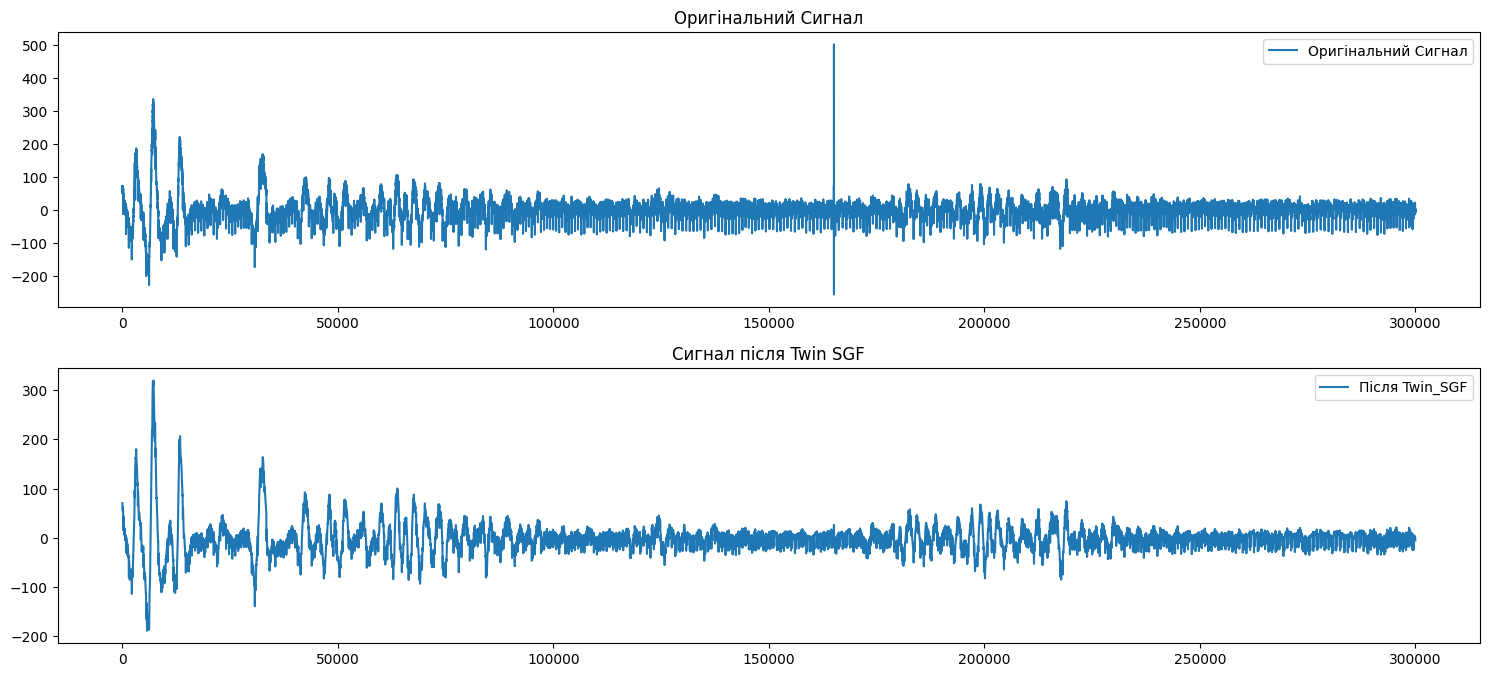

SNR для файлу r08.edf: 16.99 дБ


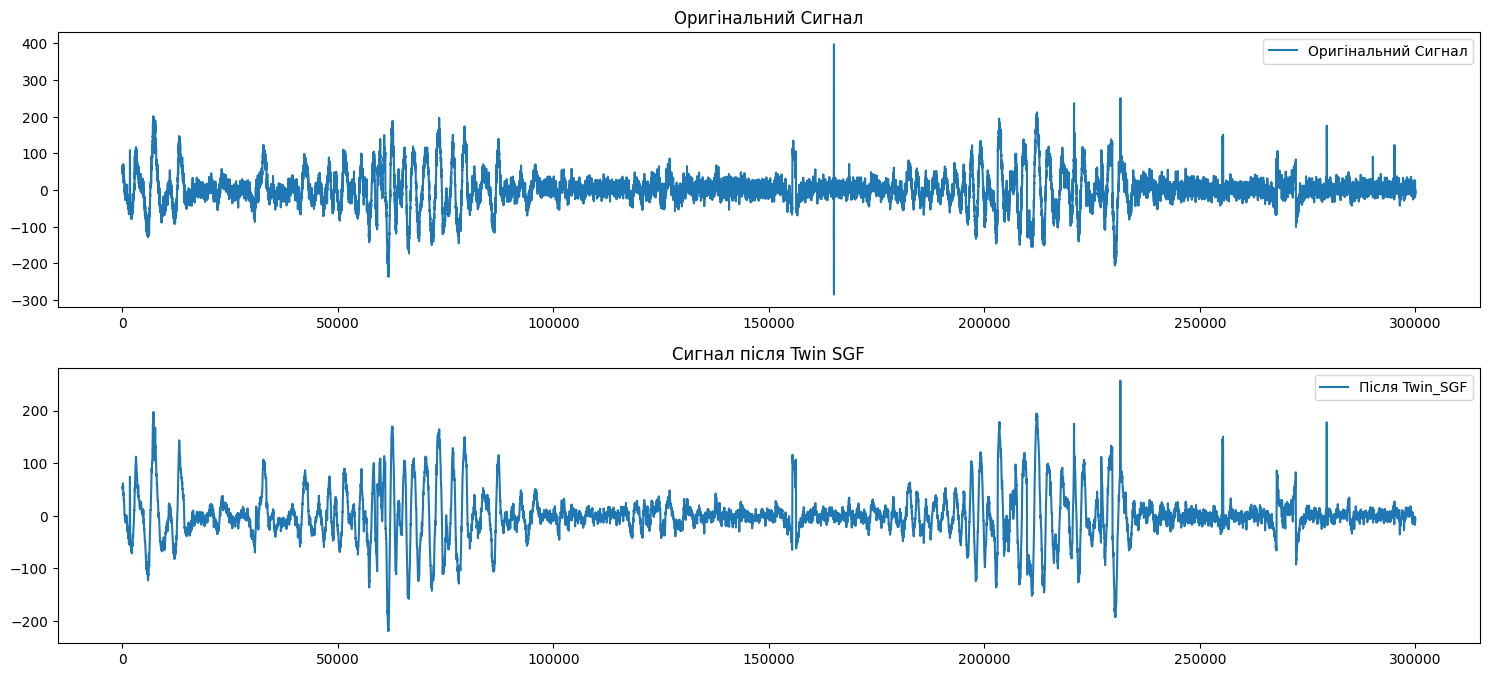

SNR для файлу r08.edf: 9.48 дБ


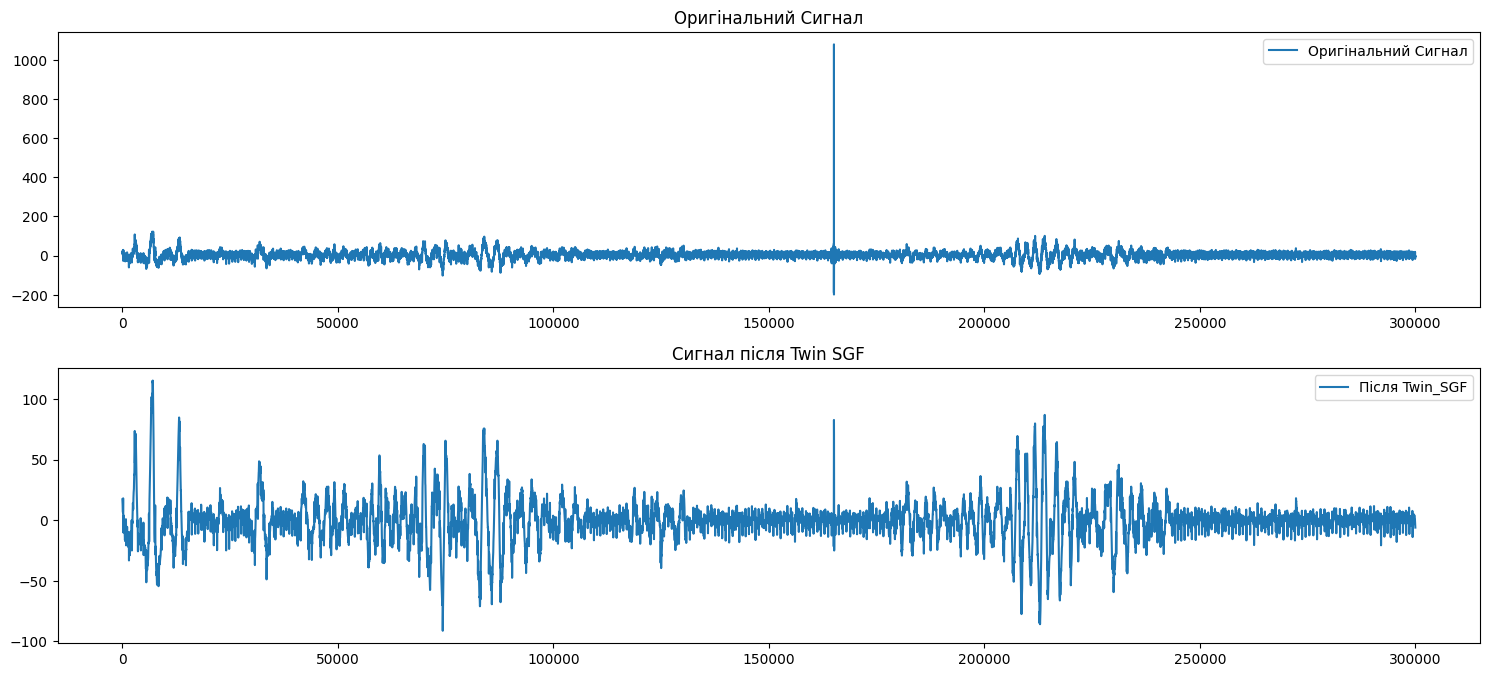

SNR для файлу r08.edf: 9.26 дБ


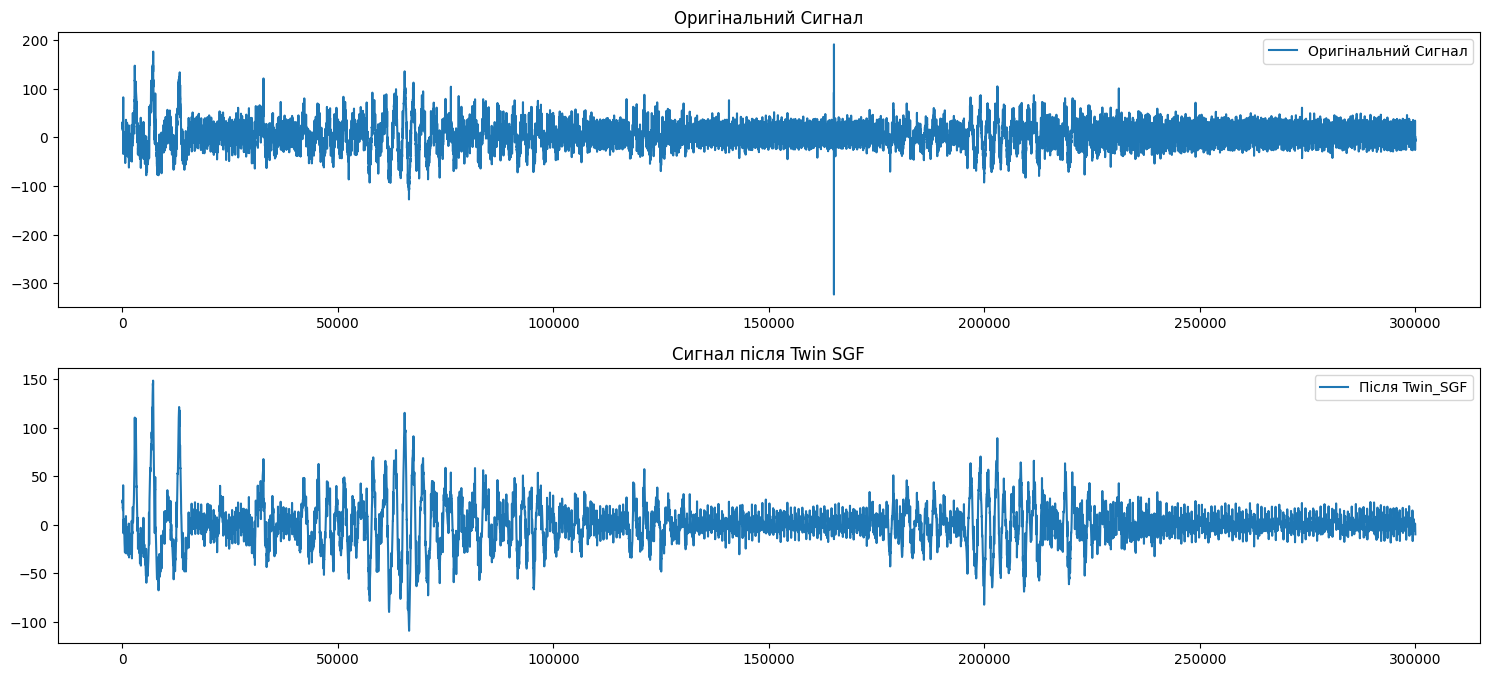

Файл: r10.edf, Каналів: 5
SNR для файлу r10.edf: 18.46 дБ


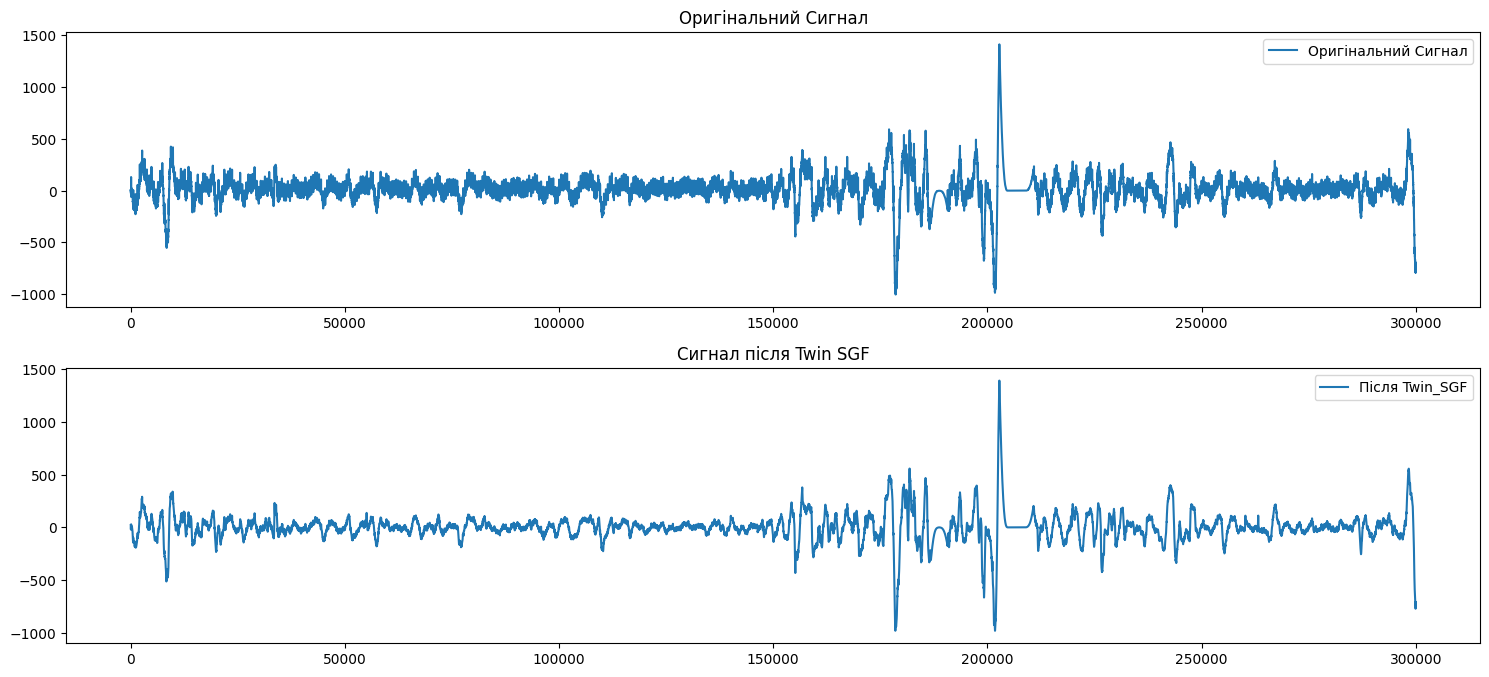

SNR для файлу r10.edf: 3.13 дБ


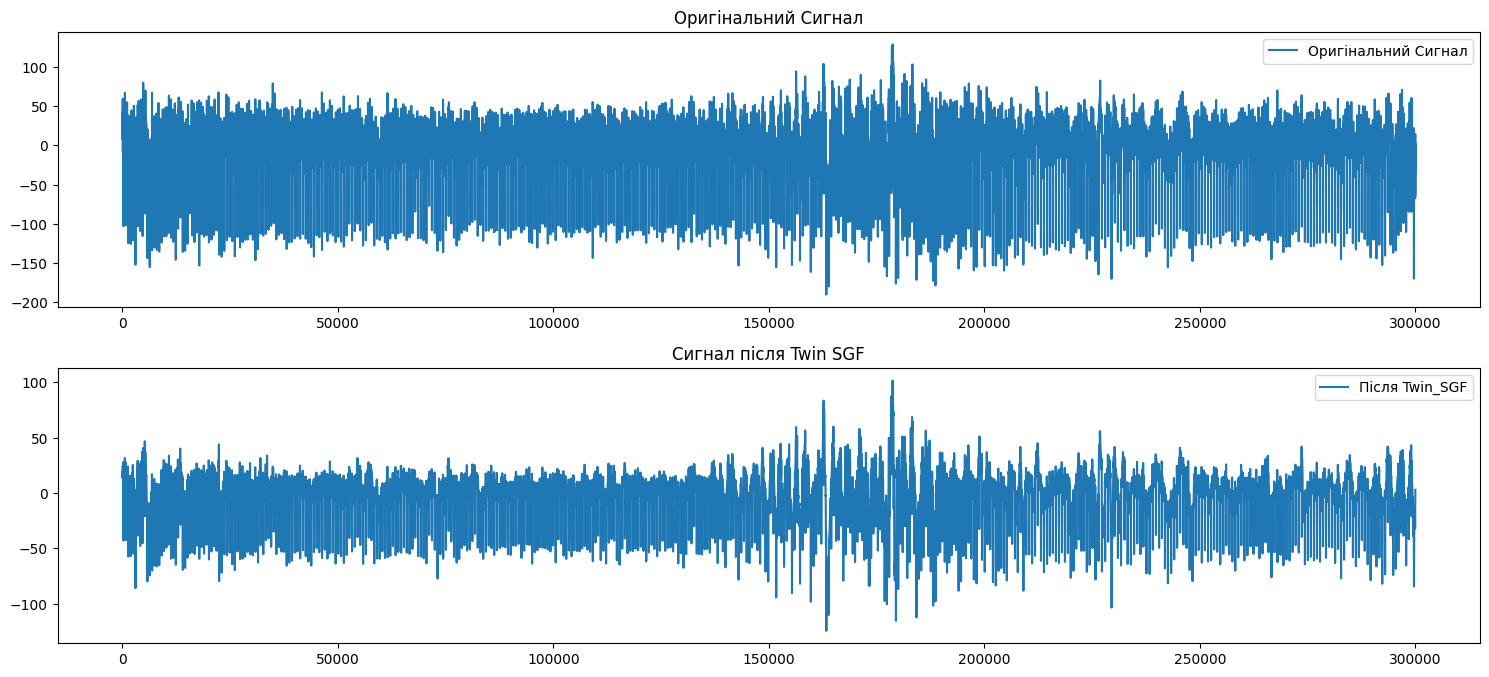

SNR для файлу r10.edf: 4.08 дБ


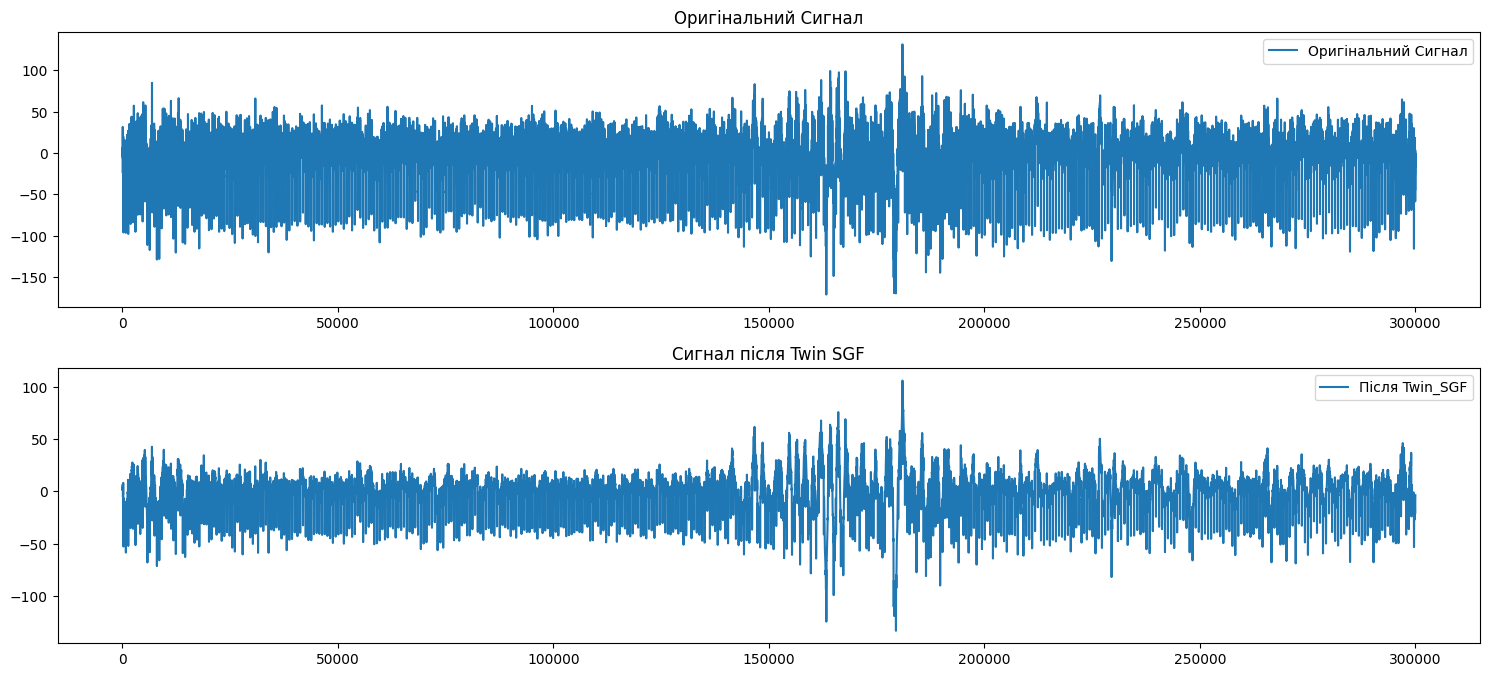

SNR для файлу r10.edf: -4.39 дБ


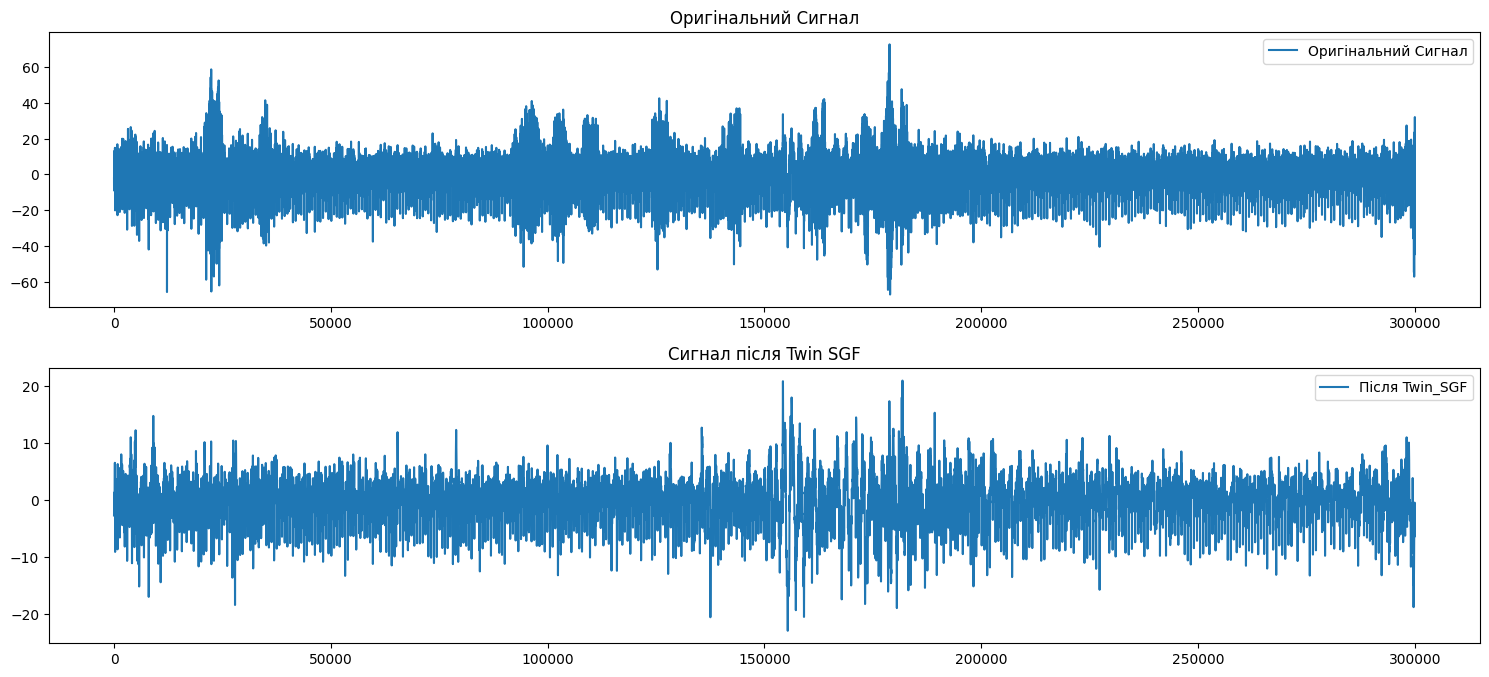

SNR для файлу r10.edf: 0.18 дБ


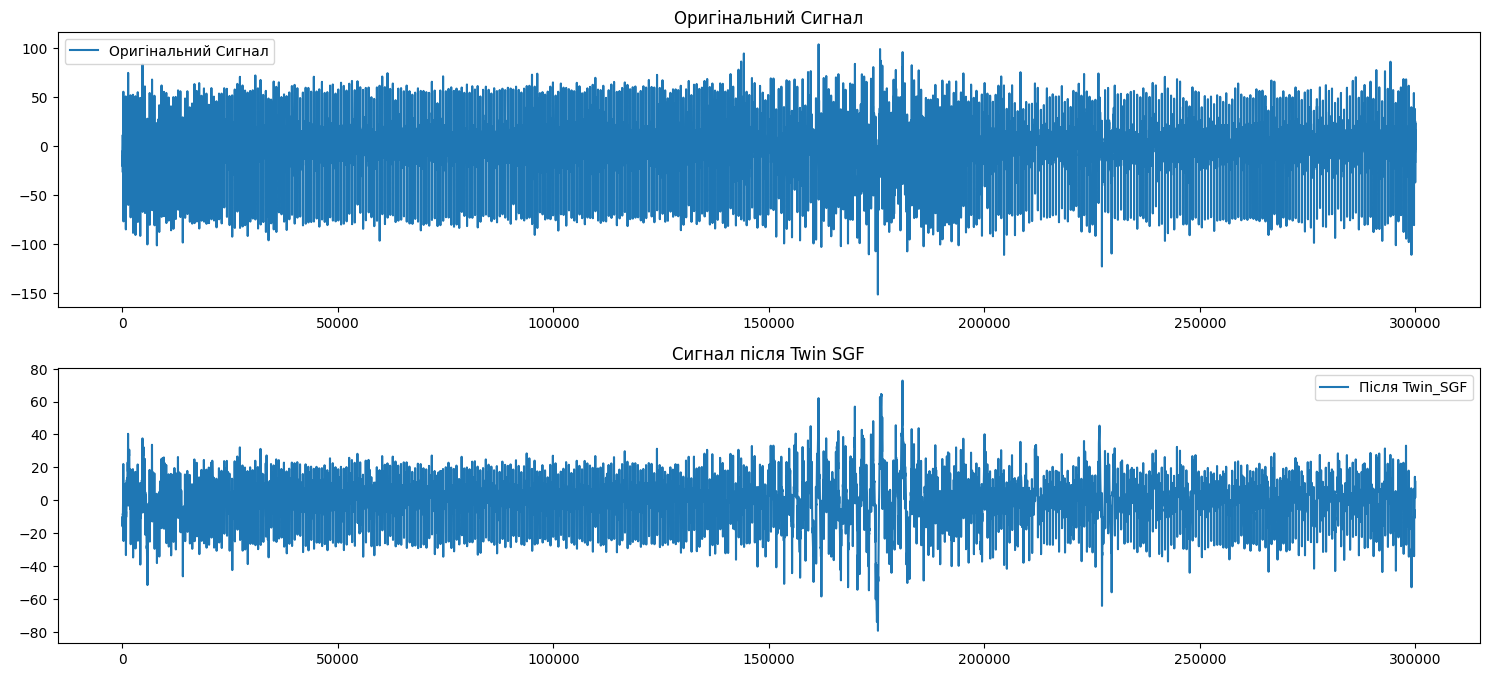

In [9]:
folder_path = "./abdominal-and-direct-fetal-ecg-database-1.0.0/abdominal-and-direct-fetal-ecg-database-1.0.0"

for file_name in os.listdir(folder_path):
    if file_name.endswith(".edf"):
        file_path = os.path.join(folder_path, file_name)
        
        with pyedflib.EdfReader(file_path) as edf_file:
            num_channels = edf_file.signals_in_file
            print(f"Файл: {file_name}, Каналів: {num_channels}")
            
            for i in range(num_channels):
                signal = edf_file.readSignal(i)
                
                filtered_signal = twin_sgf(signal, 51, 3, 101, 2)          

                snr = calculate_snr(signal, filtered_signal)
                print(f"SNR для файлу {file_name}: {snr:.2f} дБ")
                
                plt.figure(figsize=(15, 10))
                
                plt.subplot(3, 1, 1)
                plt.plot(signal, label="Оригінальний Сигнал")
                plt.title("Оригінальний Сигнал")
                plt.legend()
                
                plt.subplot(3, 1, 2)
                plt.plot(filtered_signal, label="Після Twin_SGF")
                plt.title("Сигнал після Twin SGF")
                plt.legend()
                
                plt.tight_layout()
                plt.show()

## 6



Ізолінія:
метод визначення місцезнаходження QRS комплексу у сигналі ЕКГ. Його суть полягає у виявленні ділянок QRS комплексу із подальшим накладанням ізолінії на ці ділянки. Це дозволяє отримати очищений сигнал для подальшого аналізу.

In [11]:
def detect_qrs(signal):
    fs = 1000
    nyq = 0.5 * fs
    low = 5 / nyq
    high = 50 / nyq
    b, a = butter(4, [low, high], btype='band', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    peaks, _ = find_peaks(np.abs(filtered_signal), height=0.5, distance=50)
    return peaks

Файл: r01.edf, Каналів: 5
SNR для файлу r01.edf: 12.06 дБ


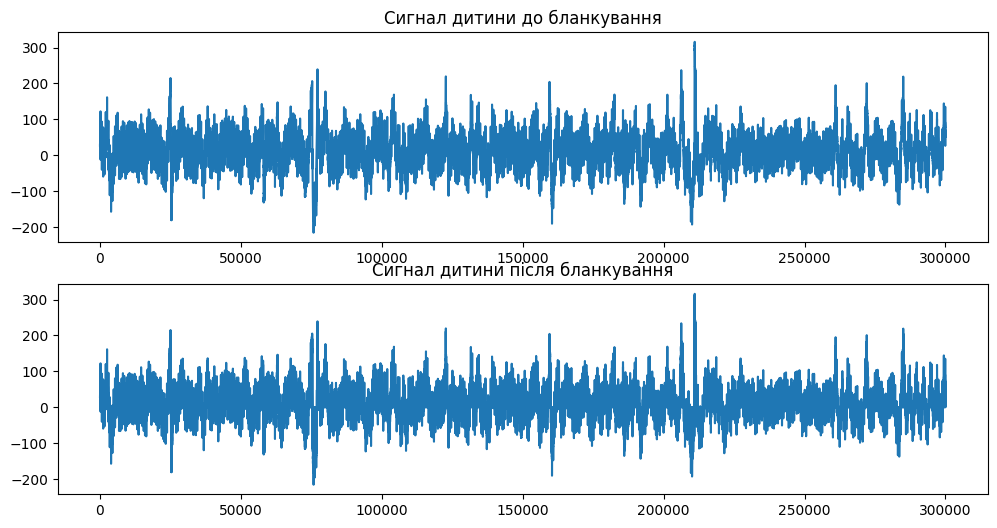

Файл: r04.edf, Каналів: 5
SNR для файлу r04.edf: 12.59 дБ


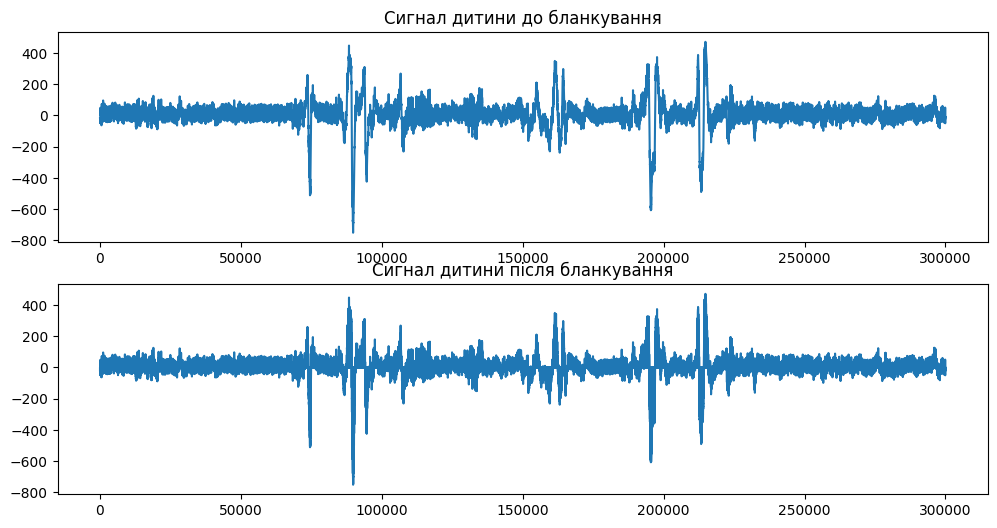

Файл: r07.edf, Каналів: 5
SNR для файлу r07.edf: 12.37 дБ


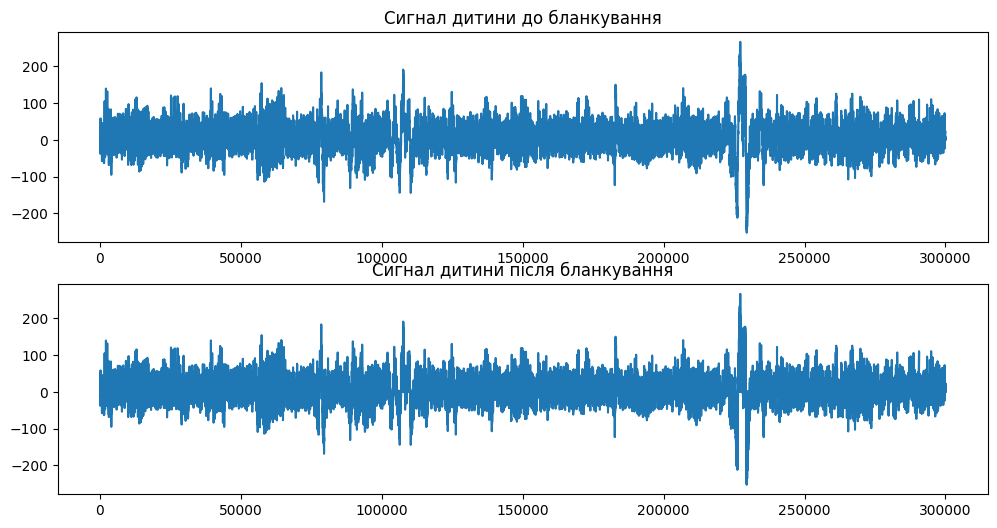

Файл: r08.edf, Каналів: 5
SNR для файлу r08.edf: 12.16 дБ


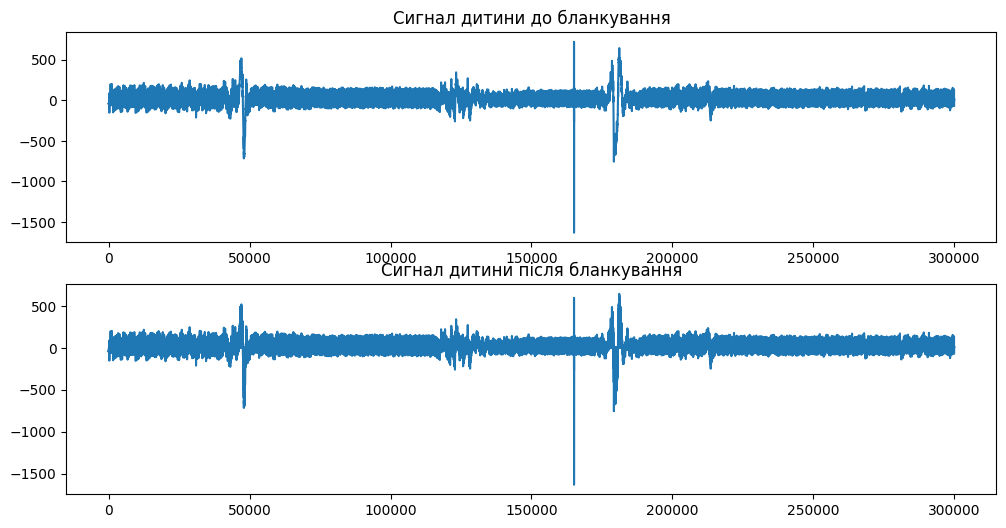

Файл: r10.edf, Каналів: 5
SNR для файлу r10.edf: 12.63 дБ


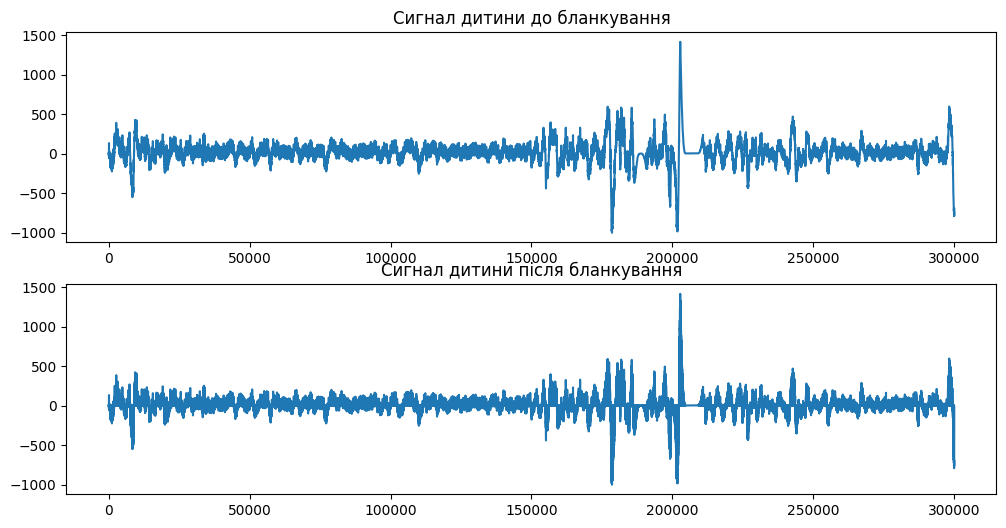

In [12]:
folder_path = "./abdominal-and-direct-fetal-ecg-database-1.0.0/abdominal-and-direct-fetal-ecg-database-1.0.0"

for file_name in os.listdir(folder_path):
        if file_name.endswith(".edf"):
                file_path = os.path.join(folder_path, file_name)

                with pyedflib.EdfReader(file_path) as edf_file:
                        num_channels = edf_file.signals_in_file
                        print(f"Файл: {file_name}, Каналів: {num_channels}")

                        child_signal = edf_file.readSignal(0)
                        maternal_signals = [edf_file.readSignal(i) for i in range(1, num_channels)]

                        maternal_qrs = []
                        for maternal_signal in maternal_signals:
                                maternal_qrs.extend(detect_qrs(maternal_signal))

                        processed_child_signal = child_signal.copy()
                        for idx in maternal_qrs:
                                processed_child_signal[idx] = 0
                        
                        snr = calculate_snr(child_signal, processed_child_signal)
                        print(f"SNR для файлу {file_name}: {snr:.2f} дБ")
                
                        plt.figure(figsize=(12, 6))

                        plt.subplot(2, 1, 1)
                        plt.plot(child_signal)
                        plt.title("Сигнал дитини до бланкування")

                        plt.subplot(2, 1, 2)
                        plt.plot(processed_child_signal)
                        plt.title("Сигнал дитини після бланкування")

                        plt.show()